<a href="https://colab.research.google.com/github/ronnief1/Polyp-Segmentation/blob/main/hyperparameter_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libs
! pip install catalyst==19.04rc1

### please update Albumentations to latest version for `Lambda` transform support
!pip install -U git+https://github.com/albu/albumentations@bdd6a4e
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading data

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from catalyst.dl.utils import UtilsFactory
import albumentations as albu
import torch
import numpy as np
import pandas as pd
import gc
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
from catalyst.dl.callbacks import EarlyStoppingCallback
from catalyst.dl.experiments import SupervisedRunner
import collections
from catalyst.dl.callbacks import InferCallback, CheckpointCallback

In [4]:
DATA_DIR = './drive/MyDrive/ColabNotebooks/AppliedDeepLearning/Kvasir-SEG/output/'

In [5]:
x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train/masks')

x_valid_dir = os.path.join(DATA_DIR, 'val/images')
y_valid_dir = os.path.join(DATA_DIR, 'val/masks')

x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/masks')

In [6]:
# helper function for data visualization
def visualize(save=False, folder=None, number=None, **images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
        if save:
          plt.savefig(folder + '/predicted' + str(number) + '.jpg')     
    plt.show()

### Dataloader

In [7]:
class Dataset(BaseDataset):
    """Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['polyp', 'background']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask[np.where(mask < 8)] = 0
        mask[np.where(mask > 8)] = 255
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

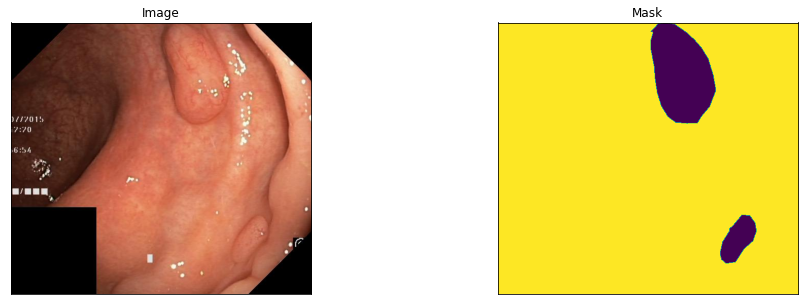

In [8]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['polyp'])

image, mask = dataset[5] # get some sample
visualize(save=True, folder='./drive/MyDrive/ColabNotebooks/AppliedDeepLearning/', number='0',
    image=image, 
    mask=mask.squeeze(),
)

### Augmentations

In [9]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        #albu.RandomCrop(height=320, width=320, always_apply=True, p=1),
        
        albu.Resize(576, 736, always_apply=True, p=1),
        

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        #lbu.PadIfNeeded(384, 480)
        albu.Resize(576, 736)
        #albu.RandomCrop(height=320, width=320, always_apply=True, p=1),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [10]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['polyp', 'background'],
)

# same image with different random transforms
#for i in range(5):
#    image, mask = augmented_dataset[1]
#    visualize(image=image, mask=mask)

## Create model and train

In [11]:
hps = pd.read_csv('./drive/MyDrive/ColabNotebooks/AppliedDeepLearning/hyperparameters_unetplusplus.csv')

In [12]:
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

CLASSES = ['polyp', 'background']
ACTIVATION = 'sigmoid'
ENCODER = 'mobilenet_v2'

NUM_EXPS = hps.shape[0]

running experiment number 15


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1734: UserWarning:

Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even fr

0/20 * Epoch (train): 100% 200/200 [01:46<00:00,  1.87it/s, _fps=133.989, loss=0.543]
0/20 * Epoch (valid): 100% 100/100 [00:44<00:00,  2.25it/s, _fps=56.600, loss=0.480]
[2022-11-19 13:19:52,765] 
0/20 * Epoch 0 (train): _fps=54.9072 | base/batch_time=0.2268 | base/data_time=0.1277 | base/lr=0.0010 | base/model_time=0.0991 | base/momentum=0.9000 | loss=0.5682
0/20 * Epoch 0 (valid): _fps=29.6738 | base/batch_time=0.4172 | base/data_time=0.3977 | base/lr=0.0010 | base/model_time=0.0194 | base/momentum=0.9000 | loss=0.4965


INFO:metrics:
0/20 * Epoch 0 (train): _fps=54.9072 | base/batch_time=0.2268 | base/data_time=0.1277 | base/lr=0.0010 | base/model_time=0.0991 | base/momentum=0.9000 | loss=0.5682
0/20 * Epoch 0 (valid): _fps=29.6738 | base/batch_time=0.4172 | base/data_time=0.3977 | base/lr=0.0010 | base/model_time=0.0194 | base/momentum=0.9000 | loss=0.4965


1/20 * Epoch (train): 100% 200/200 [01:31<00:00,  2.18it/s, _fps=134.429, loss=0.538]
1/20 * Epoch (valid): 100% 100/100 [00:05<00:00, 16.94it/s, _fps=50.687, loss=0.458]
[2022-11-19 13:21:30,899] 
1/20 * Epoch 1 (train): _fps=50.7063 | base/batch_time=0.1551 | base/data_time=0.0917 | base/lr=0.0010 | base/model_time=0.0634 | base/momentum=0.9000 | loss=0.5596
1/20 * Epoch 1 (valid): _fps=29.4725 | base/batch_time=0.0417 | base/data_time=0.0199 | base/lr=0.0010 | base/model_time=0.0218 | base/momentum=0.9000 | loss=0.4809


INFO:metrics:
1/20 * Epoch 1 (train): _fps=50.7063 | base/batch_time=0.1551 | base/data_time=0.0917 | base/lr=0.0010 | base/model_time=0.0634 | base/momentum=0.9000 | loss=0.5596
1/20 * Epoch 1 (valid): _fps=29.4725 | base/batch_time=0.0417 | base/data_time=0.0199 | base/lr=0.0010 | base/model_time=0.0218 | base/momentum=0.9000 | loss=0.4809


2/20 * Epoch (train): 100% 200/200 [01:29<00:00,  2.24it/s, _fps=132.637, loss=0.524]
2/20 * Epoch (valid): 100% 100/100 [00:06<00:00, 15.85it/s, _fps=51.636, loss=0.466]
[2022-11-19 13:23:06,695] 
2/20 * Epoch 2 (train): _fps=56.2535 | base/batch_time=0.1397 | base/data_time=0.0941 | base/lr=0.0010 | base/model_time=0.0455 | base/momentum=0.9000 | loss=0.5481
2/20 * Epoch 2 (valid): _fps=28.6777 | base/batch_time=0.0442 | base/data_time=0.0206 | base/lr=0.0010 | base/model_time=0.0235 | base/momentum=0.9000 | loss=0.4833


INFO:metrics:
2/20 * Epoch 2 (train): _fps=56.2535 | base/batch_time=0.1397 | base/data_time=0.0941 | base/lr=0.0010 | base/model_time=0.0455 | base/momentum=0.9000 | loss=0.5481
2/20 * Epoch 2 (valid): _fps=28.6777 | base/batch_time=0.0442 | base/data_time=0.0206 | base/lr=0.0010 | base/model_time=0.0235 | base/momentum=0.9000 | loss=0.4833


3/20 * Epoch (train): 100% 200/200 [01:32<00:00,  2.16it/s, _fps=138.278, loss=0.592]
3/20 * Epoch (valid): 100% 100/100 [00:08<00:00, 11.44it/s, _fps=65.238, loss=0.455]
[2022-11-19 13:24:48,512] 
3/20 * Epoch 3 (train): _fps=57.9921 | base/batch_time=0.1485 | base/data_time=0.1004 | base/lr=0.0010 | base/model_time=0.0480 | base/momentum=0.9000 | loss=0.5529
3/20 * Epoch 3 (valid): _fps=20.5199 | base/batch_time=0.0652 | base/data_time=0.0281 | base/lr=0.0010 | base/model_time=0.0369 | base/momentum=0.9000 | loss=0.4727


INFO:metrics:
3/20 * Epoch 3 (train): _fps=57.9921 | base/batch_time=0.1485 | base/data_time=0.1004 | base/lr=0.0010 | base/model_time=0.0480 | base/momentum=0.9000 | loss=0.5529
3/20 * Epoch 3 (valid): _fps=20.5199 | base/batch_time=0.0652 | base/data_time=0.0281 | base/lr=0.0010 | base/model_time=0.0369 | base/momentum=0.9000 | loss=0.4727


4/20 * Epoch (train): 100% 200/200 [01:26<00:00,  2.31it/s, _fps=93.620, loss=0.581]
4/20 * Epoch (valid): 100% 100/100 [00:08<00:00, 11.40it/s, _fps=49.954, loss=0.449]
[2022-11-19 13:26:24,496] 
4/20 * Epoch 4 (train): _fps=56.8578 | base/batch_time=0.1199 | base/data_time=0.0742 | base/lr=0.0010 | base/model_time=0.0456 | base/momentum=0.9000 | loss=0.5452
4/20 * Epoch 4 (valid): _fps=19.8371 | base/batch_time=0.0637 | base/data_time=0.0269 | base/lr=0.0010 | base/model_time=0.0368 | base/momentum=0.9000 | loss=0.4677


INFO:metrics:
4/20 * Epoch 4 (train): _fps=56.8578 | base/batch_time=0.1199 | base/data_time=0.0742 | base/lr=0.0010 | base/model_time=0.0456 | base/momentum=0.9000 | loss=0.5452
4/20 * Epoch 4 (valid): _fps=19.8371 | base/batch_time=0.0637 | base/data_time=0.0269 | base/lr=0.0010 | base/model_time=0.0368 | base/momentum=0.9000 | loss=0.4677


5/20 * Epoch (train): 100% 200/200 [01:29<00:00,  2.24it/s, _fps=99.061, loss=0.514]
5/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.91it/s, _fps=50.455, loss=0.447]
[2022-11-19 13:28:01,413] 
5/20 * Epoch 5 (train): _fps=55.3588 | base/batch_time=0.1329 | base/data_time=0.0885 | base/lr=0.0010 | base/model_time=0.0443 | base/momentum=0.9000 | loss=0.5446
5/20 * Epoch 5 (valid): _fps=25.9862 | base/batch_time=0.0528 | base/data_time=0.0233 | base/lr=0.0010 | base/model_time=0.0295 | base/momentum=0.9000 | loss=0.4651


INFO:metrics:
5/20 * Epoch 5 (train): _fps=55.3588 | base/batch_time=0.1329 | base/data_time=0.0885 | base/lr=0.0010 | base/model_time=0.0443 | base/momentum=0.9000 | loss=0.5446
5/20 * Epoch 5 (valid): _fps=25.9862 | base/batch_time=0.0528 | base/data_time=0.0233 | base/lr=0.0010 | base/model_time=0.0295 | base/momentum=0.9000 | loss=0.4651


6/20 * Epoch (train): 100% 200/200 [01:27<00:00,  2.29it/s, _fps=83.405, loss=0.589]
6/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 12.94it/s, _fps=41.940, loss=0.442]
[2022-11-19 13:29:36,910] 
6/20 * Epoch 6 (train): _fps=58.1789 | base/batch_time=0.1232 | base/data_time=0.0776 | base/lr=0.0010 | base/model_time=0.0453 | base/momentum=0.9000 | loss=0.5431
6/20 * Epoch 6 (valid): _fps=23.9017 | base/batch_time=0.0556 | base/data_time=0.0253 | base/lr=0.0010 | base/model_time=0.0302 | base/momentum=0.9000 | loss=0.4597


INFO:metrics:
6/20 * Epoch 6 (train): _fps=58.1789 | base/batch_time=0.1232 | base/data_time=0.0776 | base/lr=0.0010 | base/model_time=0.0453 | base/momentum=0.9000 | loss=0.5431
6/20 * Epoch 6 (valid): _fps=23.9017 | base/batch_time=0.0556 | base/data_time=0.0253 | base/lr=0.0010 | base/model_time=0.0302 | base/momentum=0.9000 | loss=0.4597


7/20 * Epoch (train): 100% 200/200 [01:29<00:00,  2.24it/s, _fps=94.990, loss=0.518]
7/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.49it/s, _fps=55.901, loss=0.443]
[2022-11-19 13:31:13,787] 
7/20 * Epoch 7 (train): _fps=56.2780 | base/batch_time=0.1318 | base/data_time=0.0844 | base/lr=0.0010 | base/model_time=0.0474 | base/momentum=0.9000 | loss=0.5421
7/20 * Epoch 7 (valid): _fps=26.0557 | base/batch_time=0.0541 | base/data_time=0.0251 | base/lr=0.0010 | base/model_time=0.0290 | base/momentum=0.9000 | loss=0.4601


INFO:metrics:
7/20 * Epoch 7 (train): _fps=56.2780 | base/batch_time=0.1318 | base/data_time=0.0844 | base/lr=0.0010 | base/model_time=0.0474 | base/momentum=0.9000 | loss=0.5421
7/20 * Epoch 7 (valid): _fps=26.0557 | base/batch_time=0.0541 | base/data_time=0.0251 | base/lr=0.0010 | base/model_time=0.0290 | base/momentum=0.9000 | loss=0.4601


8/20 * Epoch (train): 100% 200/200 [01:26<00:00,  2.31it/s, _fps=91.794, loss=0.542]
8/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.17it/s, _fps=53.868, loss=0.448]
[2022-11-19 13:32:48,545] 
8/20 * Epoch 8 (train): _fps=56.5898 | base/batch_time=0.1202 | base/data_time=0.0739 | base/lr=0.0010 | base/model_time=0.0463 | base/momentum=0.9000 | loss=0.5387
8/20 * Epoch 8 (valid): _fps=25.1079 | base/batch_time=0.0555 | base/data_time=0.0231 | base/lr=0.0010 | base/model_time=0.0323 | base/momentum=0.9000 | loss=0.4628


INFO:metrics:
8/20 * Epoch 8 (train): _fps=56.5898 | base/batch_time=0.1202 | base/data_time=0.0739 | base/lr=0.0010 | base/model_time=0.0463 | base/momentum=0.9000 | loss=0.5387
8/20 * Epoch 8 (valid): _fps=25.1079 | base/batch_time=0.0555 | base/data_time=0.0231 | base/lr=0.0010 | base/model_time=0.0323 | base/momentum=0.9000 | loss=0.4628


9/20 * Epoch (train): 100% 200/200 [01:30<00:00,  2.21it/s, _fps=88.853, loss=0.523]
9/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 14.24it/s, _fps=58.571, loss=0.443]
[2022-11-19 13:34:26,527] 
9/20 * Epoch 9 (train): _fps=54.3896 | base/batch_time=0.1369 | base/data_time=0.0853 | base/lr=0.0010 | base/model_time=0.0515 | base/momentum=0.9000 | loss=0.5393
9/20 * Epoch 9 (valid): _fps=25.7677 | base/batch_time=0.0516 | base/data_time=0.0232 | base/lr=0.0010 | base/model_time=0.0283 | base/momentum=0.9000 | loss=0.4591


INFO:metrics:
9/20 * Epoch 9 (train): _fps=54.3896 | base/batch_time=0.1369 | base/data_time=0.0853 | base/lr=0.0010 | base/model_time=0.0515 | base/momentum=0.9000 | loss=0.5393
9/20 * Epoch 9 (valid): _fps=25.7677 | base/batch_time=0.0516 | base/data_time=0.0232 | base/lr=0.0010 | base/model_time=0.0283 | base/momentum=0.9000 | loss=0.4591


10/20 * Epoch (train): 100% 200/200 [01:27<00:00,  2.29it/s, _fps=88.472, loss=0.562]
10/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 14.02it/s, _fps=58.165, loss=0.443]
[2022-11-19 13:36:01,377] 
10/20 * Epoch 10 (train): _fps=54.7918 | base/batch_time=0.1245 | base/data_time=0.0778 | base/lr=0.0010 | base/model_time=0.0466 | base/momentum=0.9000 | loss=0.5347
10/20 * Epoch 10 (valid): _fps=26.1633 | base/batch_time=0.0524 | base/data_time=0.0234 | base/lr=0.0010 | base/model_time=0.0289 | base/momentum=0.9000 | loss=0.4593


INFO:metrics:
10/20 * Epoch 10 (train): _fps=54.7918 | base/batch_time=0.1245 | base/data_time=0.0778 | base/lr=0.0010 | base/model_time=0.0466 | base/momentum=0.9000 | loss=0.5347
10/20 * Epoch 10 (valid): _fps=26.1633 | base/batch_time=0.0524 | base/data_time=0.0234 | base/lr=0.0010 | base/model_time=0.0289 | base/momentum=0.9000 | loss=0.4593


11/20 * Epoch (train): 100% 200/200 [01:30<00:00,  2.21it/s, _fps=93.907, loss=0.494]
11/20 * Epoch (valid): 100% 100/100 [00:06<00:00, 16.65it/s, _fps=59.327, loss=0.443]
[2022-11-19 13:37:38,077] 
11/20 * Epoch 11 (train): _fps=52.9858 | base/batch_time=0.1381 | base/data_time=0.0843 | base/lr=0.0010 | base/model_time=0.0537 | base/momentum=0.9000 | loss=0.5400
11/20 * Epoch 11 (valid): _fps=30.3361 | base/batch_time=0.0415 | base/data_time=0.0209 | base/lr=0.0010 | base/model_time=0.0206 | base/momentum=0.9000 | loss=0.4577


INFO:metrics:
11/20 * Epoch 11 (train): _fps=52.9858 | base/batch_time=0.1381 | base/data_time=0.0843 | base/lr=0.0010 | base/model_time=0.0537 | base/momentum=0.9000 | loss=0.5400
11/20 * Epoch 11 (valid): _fps=30.3361 | base/batch_time=0.0415 | base/data_time=0.0209 | base/lr=0.0010 | base/model_time=0.0206 | base/momentum=0.9000 | loss=0.4577


12/20 * Epoch (train): 100% 200/200 [01:26<00:00,  2.30it/s, _fps=96.459, loss=0.509]
12/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.59it/s, _fps=59.355, loss=0.441]
[2022-11-19 13:39:12,834] 
12/20 * Epoch 12 (train): _fps=55.4573 | base/batch_time=0.1264 | base/data_time=0.0799 | base/lr=0.0010 | base/model_time=0.0464 | base/momentum=0.9000 | loss=0.5361
12/20 * Epoch 12 (valid): _fps=26.6634 | base/batch_time=0.0522 | base/data_time=0.0230 | base/lr=0.0010 | base/model_time=0.0291 | base/momentum=0.9000 | loss=0.4566


INFO:metrics:
12/20 * Epoch 12 (train): _fps=55.4573 | base/batch_time=0.1264 | base/data_time=0.0799 | base/lr=0.0010 | base/model_time=0.0464 | base/momentum=0.9000 | loss=0.5361
12/20 * Epoch 12 (valid): _fps=26.6634 | base/batch_time=0.0522 | base/data_time=0.0230 | base/lr=0.0010 | base/model_time=0.0291 | base/momentum=0.9000 | loss=0.4566


13/20 * Epoch (train): 100% 200/200 [01:29<00:00,  2.22it/s, _fps=83.613, loss=0.449]
13/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.95it/s, _fps=54.259, loss=0.444]
[2022-11-19 13:40:50,302] 
13/20 * Epoch 13 (train): _fps=50.7001 | base/batch_time=0.1382 | base/data_time=0.0836 | base/lr=0.0010 | base/model_time=0.0545 | base/momentum=0.9000 | loss=0.5343
13/20 * Epoch 13 (valid): _fps=26.3106 | base/batch_time=0.0522 | base/data_time=0.0240 | base/lr=0.0010 | base/model_time=0.0281 | base/momentum=0.9000 | loss=0.4588


INFO:metrics:
13/20 * Epoch 13 (train): _fps=50.7001 | base/batch_time=0.1382 | base/data_time=0.0836 | base/lr=0.0010 | base/model_time=0.0545 | base/momentum=0.9000 | loss=0.5343
13/20 * Epoch 13 (valid): _fps=26.3106 | base/batch_time=0.0522 | base/data_time=0.0240 | base/lr=0.0010 | base/model_time=0.0281 | base/momentum=0.9000 | loss=0.4588


14/20 * Epoch (train): 100% 200/200 [01:27<00:00,  2.29it/s, _fps=101.112, loss=0.508]
14/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.01it/s, _fps=45.116, loss=0.442]
[2022-11-19 13:42:25,613] 
14/20 * Epoch 14 (train): _fps=54.0231 | base/batch_time=0.1298 | base/data_time=0.0813 | base/lr=0.0010 | base/model_time=0.0484 | base/momentum=0.9000 | loss=0.5313
14/20 * Epoch 14 (valid): _fps=24.7014 | base/batch_time=0.0553 | base/data_time=0.0238 | base/lr=0.0010 | base/model_time=0.0314 | base/momentum=0.9000 | loss=0.4571


INFO:metrics:
14/20 * Epoch 14 (train): _fps=54.0231 | base/batch_time=0.1298 | base/data_time=0.0813 | base/lr=0.0010 | base/model_time=0.0484 | base/momentum=0.9000 | loss=0.5313
14/20 * Epoch 14 (valid): _fps=24.7014 | base/batch_time=0.0553 | base/data_time=0.0238 | base/lr=0.0010 | base/model_time=0.0314 | base/momentum=0.9000 | loss=0.4571


15/20 * Epoch (train): 100% 200/200 [01:28<00:00,  2.25it/s, _fps=97.564, loss=0.478]
15/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.12it/s, _fps=58.806, loss=0.440]
[2022-11-19 13:44:02,633] 
15/20 * Epoch 15 (train): _fps=54.7026 | base/batch_time=0.1328 | base/data_time=0.0837 | base/lr=0.0010 | base/model_time=0.0490 | base/momentum=0.9000 | loss=0.5353
15/20 * Epoch 15 (valid): _fps=24.0853 | base/batch_time=0.0565 | base/data_time=0.0256 | base/lr=0.0010 | base/model_time=0.0308 | base/momentum=0.9000 | loss=0.4556


INFO:metrics:
15/20 * Epoch 15 (train): _fps=54.7026 | base/batch_time=0.1328 | base/data_time=0.0837 | base/lr=0.0010 | base/model_time=0.0490 | base/momentum=0.9000 | loss=0.5353
15/20 * Epoch 15 (valid): _fps=24.0853 | base/batch_time=0.0565 | base/data_time=0.0256 | base/lr=0.0010 | base/model_time=0.0308 | base/momentum=0.9000 | loss=0.4556


16/20 * Epoch (train): 100% 200/200 [01:26<00:00,  2.30it/s, _fps=98.603, loss=0.546]
16/20 * Epoch (valid): 100% 100/100 [00:08<00:00, 12.24it/s, _fps=69.364, loss=0.437]
[2022-11-19 13:45:38,002] 
16/20 * Epoch 16 (train): _fps=58.3308 | base/batch_time=0.1204 | base/data_time=0.0745 | base/lr=0.0010 | base/model_time=0.0458 | base/momentum=0.9000 | loss=0.5321
16/20 * Epoch 16 (valid): _fps=23.2888 | base/batch_time=0.0599 | base/data_time=0.0273 | base/lr=0.0010 | base/model_time=0.0325 | base/momentum=0.9000 | loss=0.4531


INFO:metrics:
16/20 * Epoch 16 (train): _fps=58.3308 | base/batch_time=0.1204 | base/data_time=0.0745 | base/lr=0.0010 | base/model_time=0.0458 | base/momentum=0.9000 | loss=0.5321
16/20 * Epoch 16 (valid): _fps=23.2888 | base/batch_time=0.0599 | base/data_time=0.0273 | base/lr=0.0010 | base/model_time=0.0325 | base/momentum=0.9000 | loss=0.4531


17/20 * Epoch (train): 100% 200/200 [01:29<00:00,  2.25it/s, _fps=100.845, loss=0.550]
17/20 * Epoch (valid): 100% 100/100 [00:08<00:00, 12.07it/s, _fps=57.555, loss=0.435]
[2022-11-19 13:47:15,791] 
17/20 * Epoch 17 (train): _fps=52.8397 | base/batch_time=0.1345 | base/data_time=0.0790 | base/lr=0.0010 | base/model_time=0.0554 | base/momentum=0.9000 | loss=0.5322
17/20 * Epoch 17 (valid): _fps=22.4906 | base/batch_time=0.0602 | base/data_time=0.0269 | base/lr=0.0010 | base/model_time=0.0332 | base/momentum=0.9000 | loss=0.4521


INFO:metrics:
17/20 * Epoch 17 (train): _fps=52.8397 | base/batch_time=0.1345 | base/data_time=0.0790 | base/lr=0.0010 | base/model_time=0.0554 | base/momentum=0.9000 | loss=0.5322
17/20 * Epoch 17 (valid): _fps=22.4906 | base/batch_time=0.0602 | base/data_time=0.0269 | base/lr=0.0010 | base/model_time=0.0332 | base/momentum=0.9000 | loss=0.4521


18/20 * Epoch (train): 100% 200/200 [01:26<00:00,  2.30it/s, _fps=115.422, loss=0.466]
18/20 * Epoch (valid): 100% 100/100 [00:09<00:00, 11.02it/s, _fps=58.732, loss=0.442]
[2022-11-19 13:48:51,976] 
18/20 * Epoch 18 (train): _fps=56.1025 | base/batch_time=0.1236 | base/data_time=0.0770 | base/lr=0.0010 | base/model_time=0.0465 | base/momentum=0.9000 | loss=0.5330
18/20 * Epoch 18 (valid): _fps=19.1844 | base/batch_time=0.0684 | base/data_time=0.0295 | base/lr=0.0010 | base/model_time=0.0388 | base/momentum=0.9000 | loss=0.4568


INFO:metrics:
18/20 * Epoch 18 (train): _fps=56.1025 | base/batch_time=0.1236 | base/data_time=0.0770 | base/lr=0.0010 | base/model_time=0.0465 | base/momentum=0.9000 | loss=0.5330
18/20 * Epoch 18 (valid): _fps=19.1844 | base/batch_time=0.0684 | base/data_time=0.0295 | base/lr=0.0010 | base/model_time=0.0388 | base/momentum=0.9000 | loss=0.4568


19/20 * Epoch (train): 100% 200/200 [01:28<00:00,  2.25it/s, _fps=85.965, loss=0.615]
19/20 * Epoch (valid): 100% 100/100 [00:08<00:00, 11.78it/s, _fps=63.332, loss=0.435]
[2022-11-19 13:50:29,688] 
19/20 * Epoch 19 (train): _fps=54.9713 | base/batch_time=0.1302 | base/data_time=0.0793 | base/lr=0.0010 | base/model_time=0.0509 | base/momentum=0.9000 | loss=0.5352
19/20 * Epoch 19 (valid): _fps=21.8145 | base/batch_time=0.0617 | base/data_time=0.0282 | base/lr=0.0010 | base/model_time=0.0334 | base/momentum=0.9000 | loss=0.4512


INFO:metrics:
19/20 * Epoch 19 (train): _fps=54.9713 | base/batch_time=0.1302 | base/data_time=0.0793 | base/lr=0.0010 | base/model_time=0.0509 | base/momentum=0.9000 | loss=0.5352
19/20 * Epoch 19 (valid): _fps=21.8145 | base/batch_time=0.0617 | base/data_time=0.0282 | base/lr=0.0010 | base/model_time=0.0334 | base/momentum=0.9000 | loss=0.4512


Top best models:
drive/MyDrive/ColabNotebooks/AppliedDeepLearning/hyperparameter_logs/segmentation_notebook_experiment_15/checkpoints//train.19.pth	0.4512
drive/MyDrive/ColabNotebooks/AppliedDeepLearning/hyperparameter_logs/segmentation_notebook_experiment_15/checkpoints//train.17.pth	0.4521
drive/MyDrive/ColabNotebooks/AppliedDeepLearning/hyperparameter_logs/segmentation_notebook_experiment_15/checkpoints//train.16.pth	0.4531
=> loading checkpoint "./drive/MyDrive/ColabNotebooks/AppliedDeepLearning/hyperparameter_logs/segmentation_notebook_experiment_15/checkpoints/best.pth"
loaded checkpoint "./drive/MyDrive/ColabNotebooks/AppliedDeepLearning/hyperparameter_logs/segmentation_notebook_experiment_15/checkpoints/best.pth" (epoch 19)


Top best models:



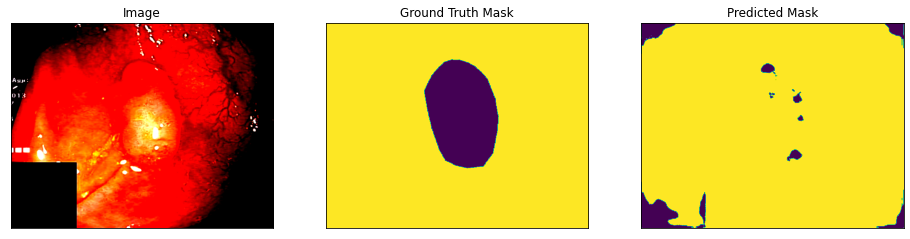

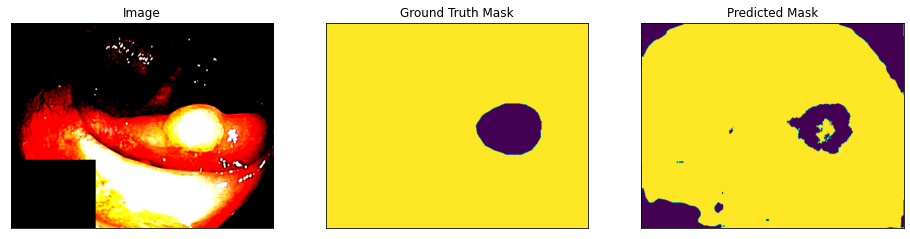

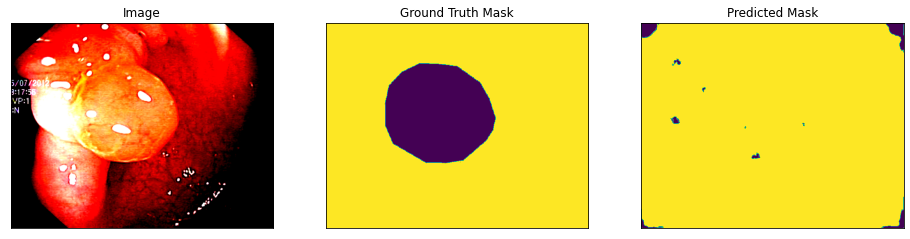

running experiment number 16


0/20 * Epoch (train): 100% 200/200 [01:46<00:00,  1.87it/s, _fps=95.589, loss=0.492]
0/20 * Epoch (valid): 100% 100/100 [00:08<00:00, 12.44it/s, _fps=42.916, loss=0.425]
[2022-11-19 13:54:06,653] 
0/20 * Epoch 0 (train): _fps=49.1906 | base/batch_time=0.1389 | base/data_time=0.0710 | base/lr=0.0010 | base/model_time=0.0677 | base/momentum=0.9000 | loss=0.5325
0/20 * Epoch 0 (valid): _fps=23.3905 | base/batch_time=0.0610 | base/data_time=0.0221 | base/lr=0.0010 | base/model_time=0.0387 | base/momentum=0.9000 | loss=0.4383


INFO:metrics:
0/20 * Epoch 0 (train): _fps=49.1906 | base/batch_time=0.1389 | base/data_time=0.0710 | base/lr=0.0010 | base/model_time=0.0677 | base/momentum=0.9000 | loss=0.5325
0/20 * Epoch 0 (valid): _fps=23.3905 | base/batch_time=0.0610 | base/data_time=0.0221 | base/lr=0.0010 | base/model_time=0.0387 | base/momentum=0.9000 | loss=0.4383


1/20 * Epoch (train): 100% 200/200 [01:47<00:00,  1.87it/s, _fps=67.508, loss=0.482]
1/20 * Epoch (valid): 100% 100/100 [00:08<00:00, 11.27it/s, _fps=28.788, loss=0.418]
[2022-11-19 13:56:04,011] 
1/20 * Epoch 1 (train): _fps=50.2282 | base/batch_time=0.1381 | base/data_time=0.0783 | base/lr=0.0010 | base/model_time=0.0597 | base/momentum=0.9000 | loss=0.5127
1/20 * Epoch 1 (valid): _fps=20.3848 | base/batch_time=0.0655 | base/data_time=0.0253 | base/lr=0.0010 | base/model_time=0.0400 | base/momentum=0.9000 | loss=0.4298


INFO:metrics:
1/20 * Epoch 1 (train): _fps=50.2282 | base/batch_time=0.1381 | base/data_time=0.0783 | base/lr=0.0010 | base/model_time=0.0597 | base/momentum=0.9000 | loss=0.5127
1/20 * Epoch 1 (valid): _fps=20.3848 | base/batch_time=0.0655 | base/data_time=0.0253 | base/lr=0.0010 | base/model_time=0.0400 | base/momentum=0.9000 | loss=0.4298


2/20 * Epoch (train): 100% 200/200 [01:46<00:00,  1.88it/s, _fps=108.658, loss=0.447]
2/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.80it/s, _fps=38.287, loss=0.420]
[2022-11-19 13:57:59,028] 
2/20 * Epoch 2 (train): _fps=54.6011 | base/batch_time=0.1389 | base/data_time=0.0914 | base/lr=0.0010 | base/model_time=0.0475 | base/momentum=0.9000 | loss=0.5023
2/20 * Epoch 2 (valid): _fps=23.2424 | base/batch_time=0.0529 | base/data_time=0.0209 | base/lr=0.0010 | base/model_time=0.0319 | base/momentum=0.9000 | loss=0.4252


INFO:metrics:
2/20 * Epoch 2 (train): _fps=54.6011 | base/batch_time=0.1389 | base/data_time=0.0914 | base/lr=0.0010 | base/model_time=0.0475 | base/momentum=0.9000 | loss=0.5023
2/20 * Epoch 2 (valid): _fps=23.2424 | base/batch_time=0.0529 | base/data_time=0.0209 | base/lr=0.0010 | base/model_time=0.0319 | base/momentum=0.9000 | loss=0.4252


3/20 * Epoch (train): 100% 200/200 [01:49<00:00,  1.82it/s, _fps=106.757, loss=0.514]
3/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.85it/s, _fps=45.692, loss=0.411]
[2022-11-19 13:59:57,115] 
3/20 * Epoch 3 (train): _fps=49.4493 | base/batch_time=0.1410 | base/data_time=0.0787 | base/lr=0.0010 | base/model_time=0.0621 | base/momentum=0.9000 | loss=0.4999
3/20 * Epoch 3 (valid): _fps=23.9495 | base/batch_time=0.0522 | base/data_time=0.0204 | base/lr=0.0010 | base/model_time=0.0317 | base/momentum=0.9000 | loss=0.4192


INFO:metrics:
3/20 * Epoch 3 (train): _fps=49.4493 | base/batch_time=0.1410 | base/data_time=0.0787 | base/lr=0.0010 | base/model_time=0.0621 | base/momentum=0.9000 | loss=0.4999
3/20 * Epoch 3 (valid): _fps=23.9495 | base/batch_time=0.0522 | base/data_time=0.0204 | base/lr=0.0010 | base/model_time=0.0317 | base/momentum=0.9000 | loss=0.4192


4/20 * Epoch (train): 100% 200/200 [01:48<00:00,  1.85it/s, _fps=111.179, loss=0.452]
4/20 * Epoch (valid): 100% 100/100 [00:09<00:00, 10.52it/s, _fps=37.251, loss=0.412]
[2022-11-19 14:01:56,339] 
4/20 * Epoch 4 (train): _fps=54.7654 | base/batch_time=0.1340 | base/data_time=0.0761 | base/lr=0.0010 | base/model_time=0.0577 | base/momentum=0.9000 | loss=0.4899
4/20 * Epoch 4 (valid): _fps=16.8240 | base/batch_time=0.0731 | base/data_time=0.0276 | base/lr=0.0010 | base/model_time=0.0455 | base/momentum=0.9000 | loss=0.4186


INFO:metrics:
4/20 * Epoch 4 (train): _fps=54.7654 | base/batch_time=0.1340 | base/data_time=0.0761 | base/lr=0.0010 | base/model_time=0.0577 | base/momentum=0.9000 | loss=0.4899
4/20 * Epoch 4 (valid): _fps=16.8240 | base/batch_time=0.0731 | base/data_time=0.0276 | base/lr=0.0010 | base/model_time=0.0455 | base/momentum=0.9000 | loss=0.4186


5/20 * Epoch (train): 100% 200/200 [01:47<00:00,  1.86it/s, _fps=99.042, loss=0.571]
5/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 14.07it/s, _fps=38.147, loss=0.407]
[2022-11-19 14:03:52,420] 
5/20 * Epoch 5 (train): _fps=51.0678 | base/batch_time=0.1395 | base/data_time=0.0797 | base/lr=0.0010 | base/model_time=0.0598 | base/momentum=0.9000 | loss=0.5009
5/20 * Epoch 5 (valid): _fps=23.9901 | base/batch_time=0.0519 | base/data_time=0.0222 | base/lr=0.0010 | base/model_time=0.0297 | base/momentum=0.9000 | loss=0.4145


INFO:metrics:
5/20 * Epoch 5 (train): _fps=51.0678 | base/batch_time=0.1395 | base/data_time=0.0797 | base/lr=0.0010 | base/model_time=0.0598 | base/momentum=0.9000 | loss=0.5009
5/20 * Epoch 5 (valid): _fps=23.9901 | base/batch_time=0.0519 | base/data_time=0.0222 | base/lr=0.0010 | base/model_time=0.0297 | base/momentum=0.9000 | loss=0.4145


6/20 * Epoch (train): 100% 200/200 [01:45<00:00,  1.90it/s, _fps=90.305, loss=0.433]
6/20 * Epoch (valid): 100% 100/100 [00:06<00:00, 14.33it/s, _fps=42.805, loss=0.406]
[2022-11-19 14:05:46,140] 
6/20 * Epoch 6 (train): _fps=54.9551 | base/batch_time=0.1271 | base/data_time=0.0735 | base/lr=0.0010 | base/model_time=0.0536 | base/momentum=0.9000 | loss=0.4919
6/20 * Epoch 6 (valid): _fps=25.1256 | base/batch_time=0.0501 | base/data_time=0.0197 | base/lr=0.0010 | base/model_time=0.0303 | base/momentum=0.9000 | loss=0.4141


INFO:metrics:
6/20 * Epoch 6 (train): _fps=54.9551 | base/batch_time=0.1271 | base/data_time=0.0735 | base/lr=0.0010 | base/model_time=0.0536 | base/momentum=0.9000 | loss=0.4919
6/20 * Epoch 6 (valid): _fps=25.1256 | base/batch_time=0.0501 | base/data_time=0.0197 | base/lr=0.0010 | base/model_time=0.0303 | base/momentum=0.9000 | loss=0.4141


7/20 * Epoch (train): 100% 200/200 [01:49<00:00,  1.82it/s, _fps=69.551, loss=0.576]
7/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 12.81it/s, _fps=38.649, loss=0.406]
[2022-11-19 14:07:45,054] 
7/20 * Epoch 7 (train): _fps=56.1582 | base/batch_time=0.1419 | base/data_time=0.0863 | base/lr=0.0010 | base/model_time=0.0555 | base/momentum=0.9000 | loss=0.4919
7/20 * Epoch 7 (valid): _fps=22.9272 | base/batch_time=0.0574 | base/data_time=0.0240 | base/lr=0.0010 | base/model_time=0.0332 | base/momentum=0.9000 | loss=0.4127


INFO:metrics:
7/20 * Epoch 7 (train): _fps=56.1582 | base/batch_time=0.1419 | base/data_time=0.0863 | base/lr=0.0010 | base/model_time=0.0555 | base/momentum=0.9000 | loss=0.4919
7/20 * Epoch 7 (valid): _fps=22.9272 | base/batch_time=0.0574 | base/data_time=0.0240 | base/lr=0.0010 | base/model_time=0.0332 | base/momentum=0.9000 | loss=0.4127


8/20 * Epoch (train): 100% 200/200 [01:45<00:00,  1.90it/s, _fps=117.118, loss=0.509]
8/20 * Epoch (valid): 100% 100/100 [00:06<00:00, 14.56it/s, _fps=39.472, loss=0.408]
[2022-11-19 14:09:38,386] 
8/20 * Epoch 8 (train): _fps=54.1699 | base/batch_time=0.1269 | base/data_time=0.0751 | base/lr=0.0010 | base/model_time=0.0518 | base/momentum=0.9000 | loss=0.4883
8/20 * Epoch 8 (valid): _fps=24.9018 | base/batch_time=0.0497 | base/data_time=0.0215 | base/lr=0.0010 | base/model_time=0.0281 | base/momentum=0.9000 | loss=0.4120


INFO:metrics:
8/20 * Epoch 8 (train): _fps=54.1699 | base/batch_time=0.1269 | base/data_time=0.0751 | base/lr=0.0010 | base/model_time=0.0518 | base/momentum=0.9000 | loss=0.4883
8/20 * Epoch 8 (valid): _fps=24.9018 | base/batch_time=0.0497 | base/data_time=0.0215 | base/lr=0.0010 | base/model_time=0.0281 | base/momentum=0.9000 | loss=0.4120


9/20 * Epoch (train): 100% 200/200 [01:45<00:00,  1.90it/s, _fps=96.697, loss=0.567]
9/20 * Epoch (valid): 100% 100/100 [00:06<00:00, 14.77it/s, _fps=56.773, loss=0.408]
[2022-11-19 14:11:31,464] 
9/20 * Epoch 9 (train): _fps=57.0105 | base/batch_time=0.1229 | base/data_time=0.0703 | base/lr=0.0010 | base/model_time=0.0525 | base/momentum=0.9000 | loss=0.4929
9/20 * Epoch 9 (valid): _fps=25.3878 | base/batch_time=0.0488 | base/data_time=0.0199 | base/lr=0.0010 | base/model_time=0.0288 | base/momentum=0.9000 | loss=0.4116


INFO:metrics:
9/20 * Epoch 9 (train): _fps=57.0105 | base/batch_time=0.1229 | base/data_time=0.0703 | base/lr=0.0010 | base/model_time=0.0525 | base/momentum=0.9000 | loss=0.4929
9/20 * Epoch 9 (valid): _fps=25.3878 | base/batch_time=0.0488 | base/data_time=0.0199 | base/lr=0.0010 | base/model_time=0.0288 | base/momentum=0.9000 | loss=0.4116


10/20 * Epoch (train): 100% 200/200 [01:48<00:00,  1.84it/s, _fps=79.463, loss=0.501]
10/20 * Epoch (valid): 100% 100/100 [00:08<00:00, 11.25it/s, _fps=37.999, loss=0.408]
[2022-11-19 14:13:30,210] 
10/20 * Epoch 10 (train): _fps=57.6290 | base/batch_time=0.1337 | base/data_time=0.0776 | base/lr=0.0010 | base/model_time=0.0561 | base/momentum=0.9000 | loss=0.4873
10/20 * Epoch 10 (valid): _fps=19.9139 | base/batch_time=0.0678 | base/data_time=0.0267 | base/lr=0.0010 | base/model_time=0.0411 | base/momentum=0.9000 | loss=0.4112


INFO:metrics:
10/20 * Epoch 10 (train): _fps=57.6290 | base/batch_time=0.1337 | base/data_time=0.0776 | base/lr=0.0010 | base/model_time=0.0561 | base/momentum=0.9000 | loss=0.4873
10/20 * Epoch 10 (valid): _fps=19.9139 | base/batch_time=0.0678 | base/data_time=0.0267 | base/lr=0.0010 | base/model_time=0.0411 | base/momentum=0.9000 | loss=0.4112


11/20 * Epoch (train): 100% 200/200 [01:45<00:00,  1.90it/s, _fps=105.721, loss=0.434]
11/20 * Epoch (valid): 100% 100/100 [00:06<00:00, 14.35it/s, _fps=50.537, loss=0.405]
[2022-11-19 14:15:23,412] 
11/20 * Epoch 11 (train): _fps=54.3491 | base/batch_time=0.1265 | base/data_time=0.0754 | base/lr=0.0010 | base/model_time=0.0509 | base/momentum=0.9000 | loss=0.4895
11/20 * Epoch 11 (valid): _fps=24.0755 | base/batch_time=0.0515 | base/data_time=0.0207 | base/lr=0.0010 | base/model_time=0.0307 | base/momentum=0.9000 | loss=0.4102


INFO:metrics:
11/20 * Epoch 11 (train): _fps=54.3491 | base/batch_time=0.1265 | base/data_time=0.0754 | base/lr=0.0010 | base/model_time=0.0509 | base/momentum=0.9000 | loss=0.4895
11/20 * Epoch 11 (valid): _fps=24.0755 | base/batch_time=0.0515 | base/data_time=0.0207 | base/lr=0.0010 | base/model_time=0.0307 | base/momentum=0.9000 | loss=0.4102


12/20 * Epoch (train): 100% 200/200 [01:47<00:00,  1.86it/s, _fps=104.928, loss=0.473]
12/20 * Epoch (valid): 100% 100/100 [00:06<00:00, 14.39it/s, _fps=51.361, loss=0.406]
[2022-11-19 14:17:18,509] 
12/20 * Epoch 12 (train): _fps=52.5730 | base/batch_time=0.1354 | base/data_time=0.0774 | base/lr=0.0010 | base/model_time=0.0580 | base/momentum=0.9000 | loss=0.4908
12/20 * Epoch 12 (valid): _fps=24.6185 | base/batch_time=0.0492 | base/data_time=0.0216 | base/lr=0.0010 | base/model_time=0.0276 | base/momentum=0.9000 | loss=0.4108


INFO:metrics:
12/20 * Epoch 12 (train): _fps=52.5730 | base/batch_time=0.1354 | base/data_time=0.0774 | base/lr=0.0010 | base/model_time=0.0580 | base/momentum=0.9000 | loss=0.4908
12/20 * Epoch 12 (valid): _fps=24.6185 | base/batch_time=0.0492 | base/data_time=0.0216 | base/lr=0.0010 | base/model_time=0.0276 | base/momentum=0.9000 | loss=0.4108


13/20 * Epoch (train): 100% 200/200 [01:46<00:00,  1.88it/s, _fps=101.320, loss=0.566]
13/20 * Epoch (valid): 100% 100/100 [00:06<00:00, 14.61it/s, _fps=44.319, loss=0.405]
[2022-11-19 14:19:13,016] 
13/20 * Epoch 13 (train): _fps=54.9137 | base/batch_time=0.1263 | base/data_time=0.0700 | base/lr=0.0010 | base/model_time=0.0563 | base/momentum=0.9000 | loss=0.4864
13/20 * Epoch 13 (valid): _fps=25.3942 | base/batch_time=0.0481 | base/data_time=0.0204 | base/lr=0.0010 | base/model_time=0.0277 | base/momentum=0.9000 | loss=0.4100


INFO:metrics:
13/20 * Epoch 13 (train): _fps=54.9137 | base/batch_time=0.1263 | base/data_time=0.0700 | base/lr=0.0010 | base/model_time=0.0563 | base/momentum=0.9000 | loss=0.4864
13/20 * Epoch 13 (valid): _fps=25.3942 | base/batch_time=0.0481 | base/data_time=0.0204 | base/lr=0.0010 | base/model_time=0.0277 | base/momentum=0.9000 | loss=0.4100


14/20 * Epoch (train): 100% 200/200 [01:49<00:00,  1.83it/s, _fps=99.924, loss=0.626]
14/20 * Epoch (valid): 100% 100/100 [00:06<00:00, 14.48it/s, _fps=42.419, loss=0.404]
[2022-11-19 14:21:10,657] 
14/20 * Epoch 14 (train): _fps=50.9487 | base/batch_time=0.1455 | base/data_time=0.0892 | base/lr=0.0010 | base/model_time=0.0561 | base/momentum=0.9000 | loss=0.4841
14/20 * Epoch 14 (valid): _fps=24.4368 | base/batch_time=0.0497 | base/data_time=0.0213 | base/lr=0.0010 | base/model_time=0.0284 | base/momentum=0.9000 | loss=0.4095


INFO:metrics:
14/20 * Epoch 14 (train): _fps=50.9487 | base/batch_time=0.1455 | base/data_time=0.0892 | base/lr=0.0010 | base/model_time=0.0561 | base/momentum=0.9000 | loss=0.4841
14/20 * Epoch 14 (valid): _fps=24.4368 | base/batch_time=0.0497 | base/data_time=0.0213 | base/lr=0.0010 | base/model_time=0.0284 | base/momentum=0.9000 | loss=0.4095


15/20 * Epoch (train): 100% 200/200 [01:46<00:00,  1.88it/s, _fps=107.833, loss=0.506]
15/20 * Epoch (valid): 100% 100/100 [00:06<00:00, 14.29it/s, _fps=41.077, loss=0.404]
[2022-11-19 14:23:05,111] 
15/20 * Epoch 15 (train): _fps=55.2756 | base/batch_time=0.1289 | base/data_time=0.0771 | base/lr=0.0010 | base/model_time=0.0517 | base/momentum=0.9000 | loss=0.4872
15/20 * Epoch 15 (valid): _fps=23.8740 | base/batch_time=0.0509 | base/data_time=0.0216 | base/lr=0.0010 | base/model_time=0.0293 | base/momentum=0.9000 | loss=0.4091


INFO:metrics:
15/20 * Epoch 15 (train): _fps=55.2756 | base/batch_time=0.1289 | base/data_time=0.0771 | base/lr=0.0010 | base/model_time=0.0517 | base/momentum=0.9000 | loss=0.4872
15/20 * Epoch 15 (valid): _fps=23.8740 | base/batch_time=0.0509 | base/data_time=0.0216 | base/lr=0.0010 | base/model_time=0.0293 | base/momentum=0.9000 | loss=0.4091


16/20 * Epoch (train): 100% 200/200 [01:49<00:00,  1.83it/s, _fps=114.366, loss=0.503]
16/20 * Epoch (valid): 100% 100/100 [00:06<00:00, 14.48it/s, _fps=41.315, loss=0.405]
[2022-11-19 14:25:02,301] 
16/20 * Epoch 16 (train): _fps=55.4083 | base/batch_time=0.1383 | base/data_time=0.0835 | base/lr=0.0010 | base/model_time=0.0548 | base/momentum=0.9000 | loss=0.4882
16/20 * Epoch 16 (valid): _fps=24.9298 | base/batch_time=0.0488 | base/data_time=0.0209 | base/lr=0.0010 | base/model_time=0.0278 | base/momentum=0.9000 | loss=0.4095


INFO:metrics:
16/20 * Epoch 16 (train): _fps=55.4083 | base/batch_time=0.1383 | base/data_time=0.0835 | base/lr=0.0010 | base/model_time=0.0548 | base/momentum=0.9000 | loss=0.4882
16/20 * Epoch 16 (valid): _fps=24.9298 | base/batch_time=0.0488 | base/data_time=0.0209 | base/lr=0.0010 | base/model_time=0.0278 | base/momentum=0.9000 | loss=0.4095


17/20 * Epoch (train): 100% 200/200 [01:47<00:00,  1.86it/s, _fps=107.734, loss=0.431]
17/20 * Epoch (valid): 100% 100/100 [00:09<00:00, 10.31it/s, _fps=33.496, loss=0.403]
[2022-11-19 14:27:00,798] 
17/20 * Epoch 17 (train): _fps=57.8893 | base/batch_time=0.1262 | base/data_time=0.0730 | base/lr=0.0010 | base/model_time=0.0531 | base/momentum=0.9000 | loss=0.4856
17/20 * Epoch 17 (valid): _fps=16.5209 | base/batch_time=0.0748 | base/data_time=0.0268 | base/lr=0.0010 | base/model_time=0.0479 | base/momentum=0.9000 | loss=0.4089


INFO:metrics:
17/20 * Epoch 17 (train): _fps=57.8893 | base/batch_time=0.1262 | base/data_time=0.0730 | base/lr=0.0010 | base/model_time=0.0531 | base/momentum=0.9000 | loss=0.4856
17/20 * Epoch 17 (valid): _fps=16.5209 | base/batch_time=0.0748 | base/data_time=0.0268 | base/lr=0.0010 | base/model_time=0.0479 | base/momentum=0.9000 | loss=0.4089


18/20 * Epoch (train): 100% 200/200 [01:43<00:00,  1.93it/s, _fps=103.095, loss=0.512]
18/20 * Epoch (valid): 100% 100/100 [00:06<00:00, 14.62it/s, _fps=43.330, loss=0.404]
[2022-11-19 14:28:51,957] 
18/20 * Epoch 18 (train): _fps=58.3614 | base/batch_time=0.1147 | base/data_time=0.0674 | base/lr=0.0010 | base/model_time=0.0473 | base/momentum=0.9000 | loss=0.4882
18/20 * Epoch 18 (valid): _fps=24.6090 | base/batch_time=0.0500 | base/data_time=0.0215 | base/lr=0.0010 | base/model_time=0.0286 | base/momentum=0.9000 | loss=0.4095


INFO:metrics:
18/20 * Epoch 18 (train): _fps=58.3614 | base/batch_time=0.1147 | base/data_time=0.0674 | base/lr=0.0010 | base/model_time=0.0473 | base/momentum=0.9000 | loss=0.4882
18/20 * Epoch 18 (valid): _fps=24.6090 | base/batch_time=0.0500 | base/data_time=0.0215 | base/lr=0.0010 | base/model_time=0.0286 | base/momentum=0.9000 | loss=0.4095


19/20 * Epoch (train): 100% 200/200 [01:46<00:00,  1.87it/s, _fps=104.808, loss=0.433]
19/20 * Epoch (valid): 100% 100/100 [00:06<00:00, 14.51it/s, _fps=42.369, loss=0.402]
[2022-11-19 14:30:46,605] 
19/20 * Epoch 19 (train): _fps=54.6182 | base/batch_time=0.1325 | base/data_time=0.0760 | base/lr=0.0010 | base/model_time=0.0563 | base/momentum=0.9000 | loss=0.4881
19/20 * Epoch 19 (valid): _fps=24.0730 | base/batch_time=0.0496 | base/data_time=0.0206 | base/lr=0.0010 | base/model_time=0.0289 | base/momentum=0.9000 | loss=0.4094


INFO:metrics:
19/20 * Epoch 19 (train): _fps=54.6182 | base/batch_time=0.1325 | base/data_time=0.0760 | base/lr=0.0010 | base/model_time=0.0563 | base/momentum=0.9000 | loss=0.4881
19/20 * Epoch 19 (valid): _fps=24.0730 | base/batch_time=0.0496 | base/data_time=0.0206 | base/lr=0.0010 | base/model_time=0.0289 | base/momentum=0.9000 | loss=0.4094


Top best models:
drive/MyDrive/ColabNotebooks/AppliedDeepLearning/hyperparameter_logs/segmentation_notebook_experiment_16/checkpoints//train.17.pth	0.4089
drive/MyDrive/ColabNotebooks/AppliedDeepLearning/hyperparameter_logs/segmentation_notebook_experiment_16/checkpoints//train.15.pth	0.4091
drive/MyDrive/ColabNotebooks/AppliedDeepLearning/hyperparameter_logs/segmentation_notebook_experiment_16/checkpoints//train.19.pth	0.4094
=> loading checkpoint "./drive/MyDrive/ColabNotebooks/AppliedDeepLearning/hyperparameter_logs/segmentation_notebook_experiment_16/checkpoints/best.pth"
loaded checkpoint "./drive/MyDrive/ColabNotebooks/AppliedDeepLearning/hyperparameter_logs/segmentation_notebook_experiment_16/checkpoints/best.pth" (epoch 17)


Top best models:



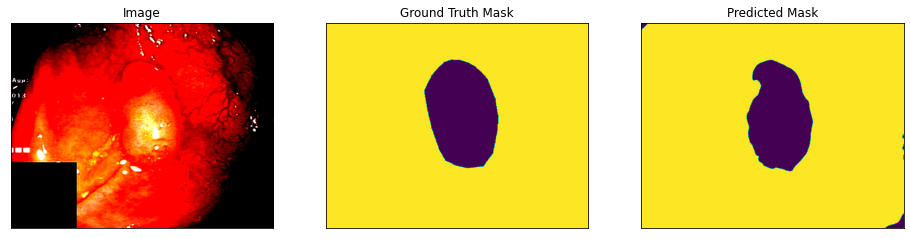

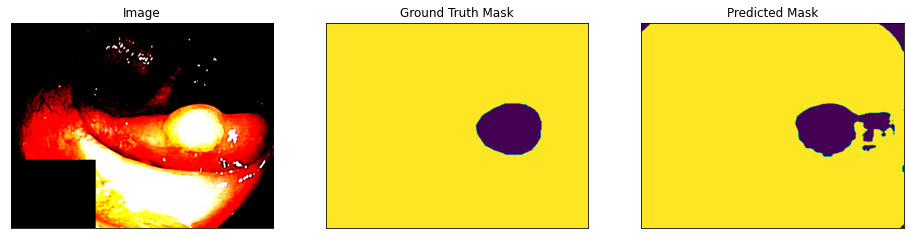

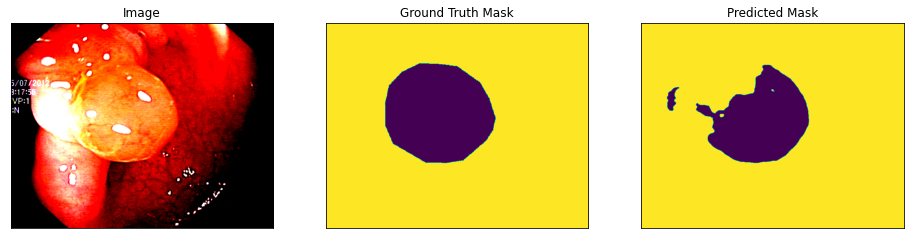

running experiment number 17


0/20 * Epoch (train): 100% 200/200 [01:46<00:00,  1.88it/s, _fps=110.634, loss=0.515]
0/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.89it/s, _fps=39.349, loss=0.458]
[2022-11-19 14:32:52,613] 
0/20 * Epoch 0 (train): _fps=55.8931 | base/batch_time=0.1286 | base/data_time=0.0755 | base/lr=0.0010 | base/model_time=0.0530 | base/momentum=0.9000 | loss=0.5519
0/20 * Epoch 0 (valid): _fps=23.7451 | base/batch_time=0.0517 | base/data_time=0.0227 | base/lr=0.0010 | base/model_time=0.0289 | base/momentum=0.9000 | loss=0.4688


INFO:metrics:
0/20 * Epoch 0 (train): _fps=55.8931 | base/batch_time=0.1286 | base/data_time=0.0755 | base/lr=0.0010 | base/model_time=0.0530 | base/momentum=0.9000 | loss=0.5519
0/20 * Epoch 0 (valid): _fps=23.7451 | base/batch_time=0.0517 | base/data_time=0.0227 | base/lr=0.0010 | base/model_time=0.0289 | base/momentum=0.9000 | loss=0.4688


1/20 * Epoch (train): 100% 200/200 [01:49<00:00,  1.82it/s, _fps=85.263, loss=0.517]
1/20 * Epoch (valid): 100% 100/100 [00:08<00:00, 11.96it/s, _fps=40.982, loss=0.451]
[2022-11-19 14:34:51,901] 
1/20 * Epoch 1 (train): _fps=52.8799 | base/batch_time=0.1456 | base/data_time=0.0931 | base/lr=0.0010 | base/model_time=0.0524 | base/momentum=0.9000 | loss=0.5365
1/20 * Epoch 1 (valid): _fps=20.7889 | base/batch_time=0.0629 | base/data_time=0.0265 | base/lr=0.0010 | base/model_time=0.0364 | base/momentum=0.9000 | loss=0.4619


INFO:metrics:
1/20 * Epoch 1 (train): _fps=52.8799 | base/batch_time=0.1456 | base/data_time=0.0931 | base/lr=0.0010 | base/model_time=0.0524 | base/momentum=0.9000 | loss=0.5365
1/20 * Epoch 1 (valid): _fps=20.7889 | base/batch_time=0.0629 | base/data_time=0.0265 | base/lr=0.0010 | base/model_time=0.0364 | base/momentum=0.9000 | loss=0.4619


2/20 * Epoch (train): 100% 200/200 [01:45<00:00,  1.90it/s, _fps=100.376, loss=0.474]
2/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 14.24it/s, _fps=43.270, loss=0.448]
[2022-11-19 14:36:45,223] 
2/20 * Epoch 2 (train): _fps=53.6107 | base/batch_time=0.1223 | base/data_time=0.0686 | base/lr=0.0010 | base/model_time=0.0535 | base/momentum=0.9000 | loss=0.5316
2/20 * Epoch 2 (valid): _fps=23.8327 | base/batch_time=0.0515 | base/data_time=0.0212 | base/lr=0.0010 | base/model_time=0.0302 | base/momentum=0.9000 | loss=0.4611


INFO:metrics:
2/20 * Epoch 2 (train): _fps=53.6107 | base/batch_time=0.1223 | base/data_time=0.0686 | base/lr=0.0010 | base/model_time=0.0535 | base/momentum=0.9000 | loss=0.5316
2/20 * Epoch 2 (valid): _fps=23.8327 | base/batch_time=0.0515 | base/data_time=0.0212 | base/lr=0.0010 | base/model_time=0.0302 | base/momentum=0.9000 | loss=0.4611


3/20 * Epoch (train): 100% 200/200 [01:47<00:00,  1.86it/s, _fps=91.809, loss=0.644]
3/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 14.14it/s, _fps=47.003, loss=0.445]
[2022-11-19 14:38:41,016] 
3/20 * Epoch 3 (train): _fps=52.5314 | base/batch_time=0.1353 | base/data_time=0.0783 | base/lr=0.0010 | base/model_time=0.0569 | base/momentum=0.9000 | loss=0.5319
3/20 * Epoch 3 (valid): _fps=23.1343 | base/batch_time=0.0516 | base/data_time=0.0209 | base/lr=0.0010 | base/model_time=0.0307 | base/momentum=0.9000 | loss=0.4557


INFO:metrics:
3/20 * Epoch 3 (train): _fps=52.5314 | base/batch_time=0.1353 | base/data_time=0.0783 | base/lr=0.0010 | base/model_time=0.0569 | base/momentum=0.9000 | loss=0.5319
3/20 * Epoch 3 (valid): _fps=23.1343 | base/batch_time=0.0516 | base/data_time=0.0209 | base/lr=0.0010 | base/model_time=0.0307 | base/momentum=0.9000 | loss=0.4557


4/20 * Epoch (train): 100% 200/200 [01:45<00:00,  1.89it/s, _fps=91.500, loss=0.574]
4/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 14.11it/s, _fps=47.268, loss=0.442]
[2022-11-19 14:40:34,868] 
4/20 * Epoch 4 (train): _fps=53.5128 | base/batch_time=0.1267 | base/data_time=0.0717 | base/lr=0.0010 | base/model_time=0.0550 | base/momentum=0.9000 | loss=0.5368
4/20 * Epoch 4 (valid): _fps=23.1351 | base/batch_time=0.0522 | base/data_time=0.0224 | base/lr=0.0010 | base/model_time=0.0298 | base/momentum=0.9000 | loss=0.4519


INFO:metrics:
4/20 * Epoch 4 (train): _fps=53.5128 | base/batch_time=0.1267 | base/data_time=0.0717 | base/lr=0.0010 | base/model_time=0.0550 | base/momentum=0.9000 | loss=0.5368
4/20 * Epoch 4 (valid): _fps=23.1351 | base/batch_time=0.0522 | base/data_time=0.0224 | base/lr=0.0010 | base/model_time=0.0298 | base/momentum=0.9000 | loss=0.4519


5/20 * Epoch (train): 100% 200/200 [01:48<00:00,  1.84it/s, _fps=102.226, loss=0.457]
5/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 14.17it/s, _fps=32.294, loss=0.443]
[2022-11-19 14:42:31,811] 
5/20 * Epoch 5 (train): _fps=53.3171 | base/batch_time=0.1404 | base/data_time=0.0803 | base/lr=0.0010 | base/model_time=0.0601 | base/momentum=0.9000 | loss=0.5227
5/20 * Epoch 5 (valid): _fps=23.7912 | base/batch_time=0.0507 | base/data_time=0.0224 | base/lr=0.0010 | base/model_time=0.0282 | base/momentum=0.9000 | loss=0.4529


INFO:metrics:
5/20 * Epoch 5 (train): _fps=53.3171 | base/batch_time=0.1404 | base/data_time=0.0803 | base/lr=0.0010 | base/model_time=0.0601 | base/momentum=0.9000 | loss=0.5227
5/20 * Epoch 5 (valid): _fps=23.7912 | base/batch_time=0.0507 | base/data_time=0.0224 | base/lr=0.0010 | base/model_time=0.0282 | base/momentum=0.9000 | loss=0.4529


6/20 * Epoch (train): 100% 200/200 [01:45<00:00,  1.90it/s, _fps=97.089, loss=0.483]
6/20 * Epoch (valid): 100% 100/100 [00:09<00:00, 10.31it/s, _fps=33.631, loss=0.444]
[2022-11-19 14:44:27,838] 
6/20 * Epoch 6 (train): _fps=59.1594 | base/batch_time=0.1252 | base/data_time=0.0811 | base/lr=0.0010 | base/model_time=0.0440 | base/momentum=0.9000 | loss=0.5252
6/20 * Epoch 6 (valid): _fps=15.8578 | base/batch_time=0.0750 | base/data_time=0.0261 | base/lr=0.0010 | base/model_time=0.0489 | base/momentum=0.9000 | loss=0.4535


INFO:metrics:
6/20 * Epoch 6 (train): _fps=59.1594 | base/batch_time=0.1252 | base/data_time=0.0811 | base/lr=0.0010 | base/model_time=0.0440 | base/momentum=0.9000 | loss=0.5252
6/20 * Epoch 6 (valid): _fps=15.8578 | base/batch_time=0.0750 | base/data_time=0.0261 | base/lr=0.0010 | base/model_time=0.0489 | base/momentum=0.9000 | loss=0.4535


7/20 * Epoch (train): 100% 200/200 [01:45<00:00,  1.90it/s, _fps=98.597, loss=0.523]
7/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 14.26it/s, _fps=48.949, loss=0.439]
[2022-11-19 14:46:21,433] 
7/20 * Epoch 7 (train): _fps=54.1687 | base/batch_time=0.1273 | base/data_time=0.0779 | base/lr=0.0010 | base/model_time=0.0493 | base/momentum=0.9000 | loss=0.5251
7/20 * Epoch 7 (valid): _fps=24.4613 | base/batch_time=0.0503 | base/data_time=0.0229 | base/lr=0.0010 | base/model_time=0.0273 | base/momentum=0.9000 | loss=0.4502


INFO:metrics:
7/20 * Epoch 7 (train): _fps=54.1687 | base/batch_time=0.1273 | base/data_time=0.0779 | base/lr=0.0010 | base/model_time=0.0493 | base/momentum=0.9000 | loss=0.5251
7/20 * Epoch 7 (valid): _fps=24.4613 | base/batch_time=0.0503 | base/data_time=0.0229 | base/lr=0.0010 | base/model_time=0.0273 | base/momentum=0.9000 | loss=0.4502


8/20 * Epoch (train): 100% 200/200 [01:43<00:00,  1.93it/s, _fps=104.722, loss=0.659]
8/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 14.22it/s, _fps=40.549, loss=0.440]
[2022-11-19 14:48:13,184] 
8/20 * Epoch 8 (train): _fps=54.7594 | base/batch_time=0.1168 | base/data_time=0.0659 | base/lr=0.0010 | base/model_time=0.0509 | base/momentum=0.9000 | loss=0.5260
8/20 * Epoch 8 (valid): _fps=23.7482 | base/batch_time=0.0515 | base/data_time=0.0215 | base/lr=0.0010 | base/model_time=0.0300 | base/momentum=0.9000 | loss=0.4490


INFO:metrics:
8/20 * Epoch 8 (train): _fps=54.7594 | base/batch_time=0.1168 | base/data_time=0.0659 | base/lr=0.0010 | base/model_time=0.0509 | base/momentum=0.9000 | loss=0.5260
8/20 * Epoch 8 (valid): _fps=23.7482 | base/batch_time=0.0515 | base/data_time=0.0215 | base/lr=0.0010 | base/model_time=0.0300 | base/momentum=0.9000 | loss=0.4490


9/20 * Epoch (train): 100% 200/200 [01:46<00:00,  1.88it/s, _fps=101.887, loss=0.560]
9/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 14.11it/s, _fps=38.008, loss=0.443]
[2022-11-19 14:50:07,289] 
9/20 * Epoch 9 (train): _fps=52.7140 | base/batch_time=0.1311 | base/data_time=0.0754 | base/lr=0.0010 | base/model_time=0.0557 | base/momentum=0.9000 | loss=0.5287
9/20 * Epoch 9 (valid): _fps=23.4806 | base/batch_time=0.0508 | base/data_time=0.0219 | base/lr=0.0010 | base/model_time=0.0289 | base/momentum=0.9000 | loss=0.4507


INFO:metrics:
9/20 * Epoch 9 (train): _fps=52.7140 | base/batch_time=0.1311 | base/data_time=0.0754 | base/lr=0.0010 | base/model_time=0.0557 | base/momentum=0.9000 | loss=0.5287
9/20 * Epoch 9 (valid): _fps=23.4806 | base/batch_time=0.0508 | base/data_time=0.0219 | base/lr=0.0010 | base/model_time=0.0289 | base/momentum=0.9000 | loss=0.4507


10/20 * Epoch (train): 100% 200/200 [01:45<00:00,  1.90it/s, _fps=85.392, loss=0.479]
10/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 14.07it/s, _fps=38.957, loss=0.438]
[2022-11-19 14:52:01,091] 
10/20 * Epoch 10 (train): _fps=54.9666 | base/batch_time=0.1266 | base/data_time=0.0739 | base/lr=0.0010 | base/model_time=0.0527 | base/momentum=0.9000 | loss=0.5183
10/20 * Epoch 10 (valid): _fps=24.1081 | base/batch_time=0.0504 | base/data_time=0.0213 | base/lr=0.0010 | base/model_time=0.0290 | base/momentum=0.9000 | loss=0.4482


INFO:metrics:
10/20 * Epoch 10 (train): _fps=54.9666 | base/batch_time=0.1266 | base/data_time=0.0739 | base/lr=0.0010 | base/model_time=0.0527 | base/momentum=0.9000 | loss=0.5183
10/20 * Epoch 10 (valid): _fps=24.1081 | base/batch_time=0.0504 | base/data_time=0.0213 | base/lr=0.0010 | base/model_time=0.0290 | base/momentum=0.9000 | loss=0.4482


11/20 * Epoch (train): 100% 200/200 [01:46<00:00,  1.89it/s, _fps=56.758, loss=0.639]
11/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 14.12it/s, _fps=41.668, loss=0.438]
[2022-11-19 14:53:55,436] 
11/20 * Epoch 11 (train): _fps=52.2665 | base/batch_time=0.1290 | base/data_time=0.0755 | base/lr=0.0010 | base/model_time=0.0535 | base/momentum=0.9000 | loss=0.5220
11/20 * Epoch 11 (valid): _fps=24.1525 | base/batch_time=0.0511 | base/data_time=0.0218 | base/lr=0.0010 | base/model_time=0.0293 | base/momentum=0.9000 | loss=0.4474


INFO:metrics:
11/20 * Epoch 11 (train): _fps=52.2665 | base/batch_time=0.1290 | base/data_time=0.0755 | base/lr=0.0010 | base/model_time=0.0535 | base/momentum=0.9000 | loss=0.5220
11/20 * Epoch 11 (valid): _fps=24.1525 | base/batch_time=0.0511 | base/data_time=0.0218 | base/lr=0.0010 | base/model_time=0.0293 | base/momentum=0.9000 | loss=0.4474


12/20 * Epoch (train): 100% 200/200 [01:45<00:00,  1.89it/s, _fps=103.123, loss=0.502]
12/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 14.18it/s, _fps=41.037, loss=0.437]
[2022-11-19 14:55:49,461] 
12/20 * Epoch 12 (train): _fps=55.8710 | base/batch_time=0.1261 | base/data_time=0.0729 | base/lr=0.0010 | base/model_time=0.0530 | base/momentum=0.9000 | loss=0.5135
12/20 * Epoch 12 (valid): _fps=23.7456 | base/batch_time=0.0523 | base/data_time=0.0223 | base/lr=0.0010 | base/model_time=0.0299 | base/momentum=0.9000 | loss=0.4451


INFO:metrics:
12/20 * Epoch 12 (train): _fps=55.8710 | base/batch_time=0.1261 | base/data_time=0.0729 | base/lr=0.0010 | base/model_time=0.0530 | base/momentum=0.9000 | loss=0.5135
12/20 * Epoch 12 (valid): _fps=23.7456 | base/batch_time=0.0523 | base/data_time=0.0223 | base/lr=0.0010 | base/model_time=0.0299 | base/momentum=0.9000 | loss=0.4451


13/20 * Epoch (train): 100% 200/200 [01:46<00:00,  1.88it/s, _fps=98.353, loss=0.518]
13/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 14.19it/s, _fps=41.821, loss=0.439]
[2022-11-19 14:57:43,870] 
13/20 * Epoch 13 (train): _fps=58.4162 | base/batch_time=0.1242 | base/data_time=0.0707 | base/lr=0.0010 | base/model_time=0.0533 | base/momentum=0.9000 | loss=0.5192
13/20 * Epoch 13 (valid): _fps=23.6199 | base/batch_time=0.0515 | base/data_time=0.0217 | base/lr=0.0010 | base/model_time=0.0297 | base/momentum=0.9000 | loss=0.4462


INFO:metrics:
13/20 * Epoch 13 (train): _fps=58.4162 | base/batch_time=0.1242 | base/data_time=0.0707 | base/lr=0.0010 | base/model_time=0.0533 | base/momentum=0.9000 | loss=0.5192
13/20 * Epoch 13 (valid): _fps=23.6199 | base/batch_time=0.0515 | base/data_time=0.0217 | base/lr=0.0010 | base/model_time=0.0297 | base/momentum=0.9000 | loss=0.4462


14/20 * Epoch (train): 100% 200/200 [01:49<00:00,  1.83it/s, _fps=106.357, loss=0.552]
14/20 * Epoch (valid): 100% 100/100 [00:08<00:00, 11.40it/s, _fps=29.908, loss=0.436]
[2022-11-19 14:59:43,346] 
14/20 * Epoch 14 (train): _fps=57.8439 | base/batch_time=0.1368 | base/data_time=0.0793 | base/lr=0.0010 | base/model_time=0.0575 | base/momentum=0.9000 | loss=0.5204
14/20 * Epoch 14 (valid): _fps=18.3735 | base/batch_time=0.0672 | base/data_time=0.0270 | base/lr=0.0010 | base/model_time=0.0402 | base/momentum=0.9000 | loss=0.4430


INFO:metrics:
14/20 * Epoch 14 (train): _fps=57.8439 | base/batch_time=0.1368 | base/data_time=0.0793 | base/lr=0.0010 | base/model_time=0.0575 | base/momentum=0.9000 | loss=0.5204
14/20 * Epoch 14 (valid): _fps=18.3735 | base/batch_time=0.0672 | base/data_time=0.0270 | base/lr=0.0010 | base/model_time=0.0402 | base/momentum=0.9000 | loss=0.4430


15/20 * Epoch (train): 100% 200/200 [01:43<00:00,  1.94it/s, _fps=70.038, loss=0.430]
15/20 * Epoch (valid): 100% 100/100 [00:08<00:00, 11.13it/s, _fps=36.596, loss=0.435]
[2022-11-19 15:01:36,898] 
15/20 * Epoch 15 (train): _fps=58.2179 | base/batch_time=0.1166 | base/data_time=0.0693 | base/lr=0.0010 | base/model_time=0.0473 | base/momentum=0.9000 | loss=0.5207
15/20 * Epoch 15 (valid): _fps=19.4678 | base/batch_time=0.0680 | base/data_time=0.0286 | base/lr=0.0010 | base/model_time=0.0393 | base/momentum=0.9000 | loss=0.4423


INFO:metrics:
15/20 * Epoch 15 (train): _fps=58.2179 | base/batch_time=0.1166 | base/data_time=0.0693 | base/lr=0.0010 | base/model_time=0.0473 | base/momentum=0.9000 | loss=0.5207
15/20 * Epoch 15 (valid): _fps=19.4678 | base/batch_time=0.0680 | base/data_time=0.0286 | base/lr=0.0010 | base/model_time=0.0393 | base/momentum=0.9000 | loss=0.4423


16/20 * Epoch (train): 100% 200/200 [01:45<00:00,  1.90it/s, _fps=104.902, loss=0.469]
16/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 14.21it/s, _fps=37.069, loss=0.432]
[2022-11-19 15:03:30,642] 
16/20 * Epoch 16 (train): _fps=53.2046 | base/batch_time=0.1214 | base/data_time=0.0679 | base/lr=0.0010 | base/model_time=0.0534 | base/momentum=0.9000 | loss=0.5163
16/20 * Epoch 16 (valid): _fps=24.2693 | base/batch_time=0.0505 | base/data_time=0.0216 | base/lr=0.0010 | base/model_time=0.0289 | base/momentum=0.9000 | loss=0.4393


INFO:metrics:
16/20 * Epoch 16 (train): _fps=53.2046 | base/batch_time=0.1214 | base/data_time=0.0679 | base/lr=0.0010 | base/model_time=0.0534 | base/momentum=0.9000 | loss=0.5163
16/20 * Epoch 16 (valid): _fps=24.2693 | base/batch_time=0.0505 | base/data_time=0.0216 | base/lr=0.0010 | base/model_time=0.0289 | base/momentum=0.9000 | loss=0.4393


17/20 * Epoch (train): 100% 200/200 [01:44<00:00,  1.92it/s, _fps=102.951, loss=0.451]
17/20 * Epoch (valid): 100% 100/100 [00:06<00:00, 14.29it/s, _fps=41.731, loss=0.433]
[2022-11-19 15:05:22,513] 
17/20 * Epoch 17 (train): _fps=59.1365 | base/batch_time=0.1142 | base/data_time=0.0696 | base/lr=0.0010 | base/model_time=0.0444 | base/momentum=0.9000 | loss=0.5144
17/20 * Epoch 17 (valid): _fps=24.2326 | base/batch_time=0.0508 | base/data_time=0.0217 | base/lr=0.0010 | base/model_time=0.0291 | base/momentum=0.9000 | loss=0.4393


INFO:metrics:
17/20 * Epoch 17 (train): _fps=59.1365 | base/batch_time=0.1142 | base/data_time=0.0696 | base/lr=0.0010 | base/model_time=0.0444 | base/momentum=0.9000 | loss=0.5144
17/20 * Epoch 17 (valid): _fps=24.2326 | base/batch_time=0.0508 | base/data_time=0.0217 | base/lr=0.0010 | base/model_time=0.0291 | base/momentum=0.9000 | loss=0.4393


18/20 * Epoch (train): 100% 200/200 [01:46<00:00,  1.88it/s, _fps=100.007, loss=0.525]
18/20 * Epoch (valid): 100% 100/100 [00:06<00:00, 14.33it/s, _fps=36.307, loss=0.430]
[2022-11-19 15:07:17,126] 
18/20 * Epoch 18 (train): _fps=55.0129 | base/batch_time=0.1264 | base/data_time=0.0756 | base/lr=0.0010 | base/model_time=0.0508 | base/momentum=0.9000 | loss=0.5187
18/20 * Epoch 18 (valid): _fps=24.1387 | base/batch_time=0.0506 | base/data_time=0.0206 | base/lr=0.0010 | base/model_time=0.0299 | base/momentum=0.9000 | loss=0.4372


INFO:metrics:
18/20 * Epoch 18 (train): _fps=55.0129 | base/batch_time=0.1264 | base/data_time=0.0756 | base/lr=0.0010 | base/model_time=0.0508 | base/momentum=0.9000 | loss=0.5187
18/20 * Epoch 18 (valid): _fps=24.1387 | base/batch_time=0.0506 | base/data_time=0.0206 | base/lr=0.0010 | base/model_time=0.0299 | base/momentum=0.9000 | loss=0.4372


19/20 * Epoch (train): 100% 200/200 [01:45<00:00,  1.89it/s, _fps=102.500, loss=0.472]
19/20 * Epoch (valid): 100% 100/100 [00:06<00:00, 14.29it/s, _fps=37.700, loss=0.431]
[2022-11-19 15:09:10,953] 
19/20 * Epoch 19 (train): _fps=55.9606 | base/batch_time=0.1245 | base/data_time=0.0733 | base/lr=0.0010 | base/model_time=0.0511 | base/momentum=0.9000 | loss=0.5107
19/20 * Epoch 19 (valid): _fps=24.3081 | base/batch_time=0.0503 | base/data_time=0.0219 | base/lr=0.0010 | base/model_time=0.0284 | base/momentum=0.9000 | loss=0.4378


INFO:metrics:
19/20 * Epoch 19 (train): _fps=55.9606 | base/batch_time=0.1245 | base/data_time=0.0733 | base/lr=0.0010 | base/model_time=0.0511 | base/momentum=0.9000 | loss=0.5107
19/20 * Epoch 19 (valid): _fps=24.3081 | base/batch_time=0.0503 | base/data_time=0.0219 | base/lr=0.0010 | base/model_time=0.0284 | base/momentum=0.9000 | loss=0.4378


Top best models:
drive/MyDrive/ColabNotebooks/AppliedDeepLearning/hyperparameter_logs/segmentation_notebook_experiment_17/checkpoints//train.18.pth	0.4372
drive/MyDrive/ColabNotebooks/AppliedDeepLearning/hyperparameter_logs/segmentation_notebook_experiment_17/checkpoints//train.19.pth	0.4378
drive/MyDrive/ColabNotebooks/AppliedDeepLearning/hyperparameter_logs/segmentation_notebook_experiment_17/checkpoints//train.16.pth	0.4393
=> loading checkpoint "./drive/MyDrive/ColabNotebooks/AppliedDeepLearning/hyperparameter_logs/segmentation_notebook_experiment_17/checkpoints/best.pth"
loaded checkpoint "./drive/MyDrive/ColabNotebooks/AppliedDeepLearning/hyperparameter_logs/segmentation_notebook_experiment_17/checkpoints/best.pth" (epoch 18)


Top best models:



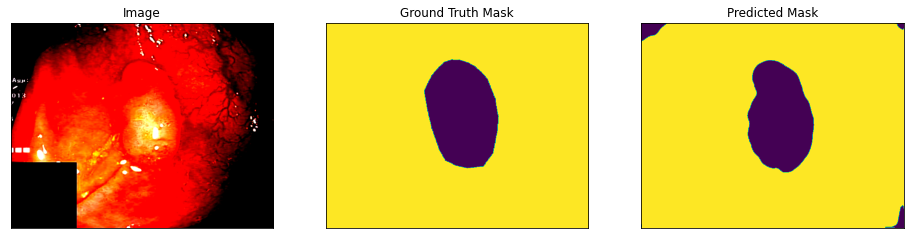

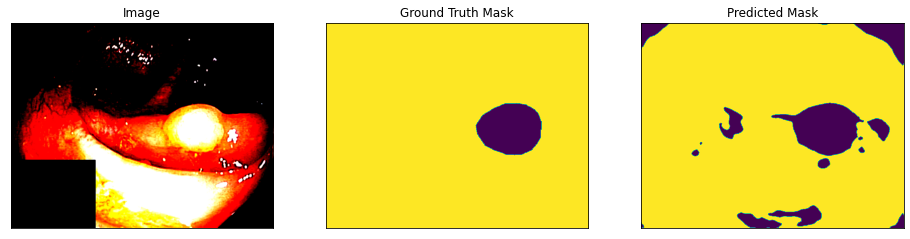

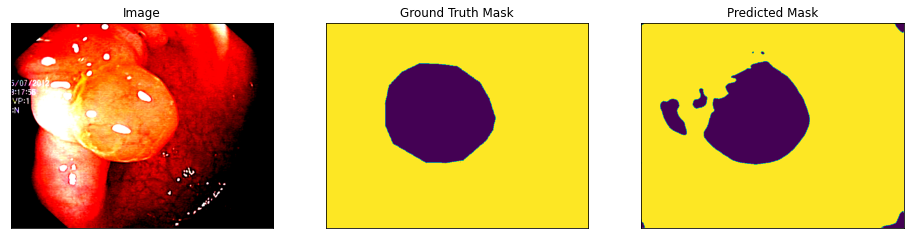

running experiment number 18


0/20 * Epoch (train): 100% 200/200 [01:48<00:00,  1.84it/s, _fps=101.301, loss=0.535]
0/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.71it/s, _fps=53.838, loss=0.460]
[2022-11-19 15:11:19,650] 
0/20 * Epoch 0 (train): _fps=52.1070 | base/batch_time=0.1333 | base/data_time=0.0757 | base/lr=0.0010 | base/model_time=0.0575 | base/momentum=0.9000 | loss=0.5551
0/20 * Epoch 0 (valid): _fps=22.9907 | base/batch_time=0.0534 | base/data_time=0.0234 | base/lr=0.0010 | base/model_time=0.0300 | base/momentum=0.9000 | loss=0.4802


INFO:metrics:
0/20 * Epoch 0 (train): _fps=52.1070 | base/batch_time=0.1333 | base/data_time=0.0757 | base/lr=0.0010 | base/model_time=0.0575 | base/momentum=0.9000 | loss=0.5551
0/20 * Epoch 0 (valid): _fps=22.9907 | base/batch_time=0.0534 | base/data_time=0.0234 | base/lr=0.0010 | base/model_time=0.0300 | base/momentum=0.9000 | loss=0.4802


1/20 * Epoch (train): 100% 200/200 [01:48<00:00,  1.84it/s, _fps=93.762, loss=0.557]
1/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.06it/s, _fps=33.861, loss=0.448]
[2022-11-19 15:13:17,349] 
1/20 * Epoch 1 (train): _fps=57.5027 | base/batch_time=0.1285 | base/data_time=0.0779 | base/lr=0.0010 | base/model_time=0.0505 | base/momentum=0.9000 | loss=0.5448
1/20 * Epoch 1 (valid): _fps=21.5182 | base/batch_time=0.0562 | base/data_time=0.0235 | base/lr=0.0010 | base/model_time=0.0327 | base/momentum=0.9000 | loss=0.4694


INFO:metrics:
1/20 * Epoch 1 (train): _fps=57.5027 | base/batch_time=0.1285 | base/data_time=0.0779 | base/lr=0.0010 | base/model_time=0.0505 | base/momentum=0.9000 | loss=0.5448
1/20 * Epoch 1 (valid): _fps=21.5182 | base/batch_time=0.0562 | base/data_time=0.0235 | base/lr=0.0010 | base/model_time=0.0327 | base/momentum=0.9000 | loss=0.4694


2/20 * Epoch (train): 100% 200/200 [01:47<00:00,  1.87it/s, _fps=86.035, loss=0.619]
2/20 * Epoch (valid): 100% 100/100 [00:10<00:00,  9.77it/s, _fps=40.067, loss=0.444]
[2022-11-19 15:15:16,339] 
2/20 * Epoch 2 (train): _fps=57.9240 | base/batch_time=0.1279 | base/data_time=0.0824 | base/lr=0.0010 | base/model_time=0.0454 | base/momentum=0.9000 | loss=0.5435
2/20 * Epoch 2 (valid): _fps=16.3464 | base/batch_time=0.0788 | base/data_time=0.0318 | base/lr=0.0010 | base/model_time=0.0468 | base/momentum=0.9000 | loss=0.4625


INFO:metrics:
2/20 * Epoch 2 (train): _fps=57.9240 | base/batch_time=0.1279 | base/data_time=0.0824 | base/lr=0.0010 | base/model_time=0.0454 | base/momentum=0.9000 | loss=0.5435
2/20 * Epoch 2 (valid): _fps=16.3464 | base/batch_time=0.0788 | base/data_time=0.0318 | base/lr=0.0010 | base/model_time=0.0468 | base/momentum=0.9000 | loss=0.4625


3/20 * Epoch (train): 100% 200/200 [01:47<00:00,  1.85it/s, _fps=94.974, loss=0.562]
3/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.83it/s, _fps=42.144, loss=0.443]
[2022-11-19 15:17:12,760] 
3/20 * Epoch 3 (train): _fps=55.8107 | base/batch_time=0.1343 | base/data_time=0.0863 | base/lr=0.0010 | base/model_time=0.0480 | base/momentum=0.9000 | loss=0.5411
3/20 * Epoch 3 (valid): _fps=23.8277 | base/batch_time=0.0506 | base/data_time=0.0234 | base/lr=0.0010 | base/model_time=0.0272 | base/momentum=0.9000 | loss=0.4596


INFO:metrics:
3/20 * Epoch 3 (train): _fps=55.8107 | base/batch_time=0.1343 | base/data_time=0.0863 | base/lr=0.0010 | base/model_time=0.0480 | base/momentum=0.9000 | loss=0.5411
3/20 * Epoch 3 (valid): _fps=23.8277 | base/batch_time=0.0506 | base/data_time=0.0234 | base/lr=0.0010 | base/model_time=0.0272 | base/momentum=0.9000 | loss=0.4596


4/20 * Epoch (train): 100% 200/200 [01:44<00:00,  1.91it/s, _fps=99.719, loss=0.477]
4/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.61it/s, _fps=39.317, loss=0.443]
[2022-11-19 15:19:06,138] 
4/20 * Epoch 4 (train): _fps=55.3032 | base/batch_time=0.1178 | base/data_time=0.0720 | base/lr=0.0010 | base/model_time=0.0458 | base/momentum=0.9000 | loss=0.5345
4/20 * Epoch 4 (valid): _fps=22.7956 | base/batch_time=0.0542 | base/data_time=0.0221 | base/lr=0.0010 | base/model_time=0.0320 | base/momentum=0.9000 | loss=0.4573


INFO:metrics:
4/20 * Epoch 4 (train): _fps=55.3032 | base/batch_time=0.1178 | base/data_time=0.0720 | base/lr=0.0010 | base/model_time=0.0458 | base/momentum=0.9000 | loss=0.5345
4/20 * Epoch 4 (valid): _fps=22.7956 | base/batch_time=0.0542 | base/data_time=0.0221 | base/lr=0.0010 | base/model_time=0.0320 | base/momentum=0.9000 | loss=0.4573


5/20 * Epoch (train): 100% 200/200 [01:47<00:00,  1.87it/s, _fps=84.430, loss=0.585]
5/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.63it/s, _fps=44.460, loss=0.442]
[2022-11-19 15:21:01,842] 
5/20 * Epoch 5 (train): _fps=51.8837 | base/batch_time=0.1308 | base/data_time=0.0783 | base/lr=0.0010 | base/model_time=0.0524 | base/momentum=0.9000 | loss=0.5300
5/20 * Epoch 5 (valid): _fps=23.1111 | base/batch_time=0.0533 | base/data_time=0.0219 | base/lr=0.0010 | base/model_time=0.0313 | base/momentum=0.9000 | loss=0.4563


INFO:metrics:
5/20 * Epoch 5 (train): _fps=51.8837 | base/batch_time=0.1308 | base/data_time=0.0783 | base/lr=0.0010 | base/model_time=0.0524 | base/momentum=0.9000 | loss=0.5300
5/20 * Epoch 5 (valid): _fps=23.1111 | base/batch_time=0.0533 | base/data_time=0.0219 | base/lr=0.0010 | base/model_time=0.0313 | base/momentum=0.9000 | loss=0.4563


6/20 * Epoch (train): 100% 200/200 [01:45<00:00,  1.89it/s, _fps=97.027, loss=0.554]
6/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.78it/s, _fps=44.259, loss=0.439]
[2022-11-19 15:22:56,124] 
6/20 * Epoch 6 (train): _fps=55.1942 | base/batch_time=0.1241 | base/data_time=0.0754 | base/lr=0.0010 | base/model_time=0.0486 | base/momentum=0.9000 | loss=0.5317
6/20 * Epoch 6 (valid): _fps=23.5912 | base/batch_time=0.0519 | base/data_time=0.0225 | base/lr=0.0010 | base/model_time=0.0293 | base/momentum=0.9000 | loss=0.4539


INFO:metrics:
6/20 * Epoch 6 (train): _fps=55.1942 | base/batch_time=0.1241 | base/data_time=0.0754 | base/lr=0.0010 | base/model_time=0.0486 | base/momentum=0.9000 | loss=0.5317
6/20 * Epoch 6 (valid): _fps=23.5912 | base/batch_time=0.0519 | base/data_time=0.0225 | base/lr=0.0010 | base/model_time=0.0293 | base/momentum=0.9000 | loss=0.4539


7/20 * Epoch (train): 100% 200/200 [01:46<00:00,  1.88it/s, _fps=98.727, loss=0.553]
7/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.69it/s, _fps=41.542, loss=0.436]
[2022-11-19 15:24:51,056] 
7/20 * Epoch 7 (train): _fps=51.8049 | base/batch_time=0.1289 | base/data_time=0.0723 | base/lr=0.0010 | base/model_time=0.0565 | base/momentum=0.9000 | loss=0.5319
7/20 * Epoch 7 (valid): _fps=23.4298 | base/batch_time=0.0521 | base/data_time=0.0226 | base/lr=0.0010 | base/model_time=0.0295 | base/momentum=0.9000 | loss=0.4515


INFO:metrics:
7/20 * Epoch 7 (train): _fps=51.8049 | base/batch_time=0.1289 | base/data_time=0.0723 | base/lr=0.0010 | base/model_time=0.0565 | base/momentum=0.9000 | loss=0.5319
7/20 * Epoch 7 (valid): _fps=23.4298 | base/batch_time=0.0521 | base/data_time=0.0226 | base/lr=0.0010 | base/model_time=0.0295 | base/momentum=0.9000 | loss=0.4515


8/20 * Epoch (train): 100% 200/200 [01:45<00:00,  1.89it/s, _fps=83.900, loss=0.542]
8/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.71it/s, _fps=43.498, loss=0.439]
[2022-11-19 15:26:45,013] 
8/20 * Epoch 8 (train): _fps=54.9045 | base/batch_time=0.1295 | base/data_time=0.0786 | base/lr=0.0010 | base/model_time=0.0508 | base/momentum=0.9000 | loss=0.5252
8/20 * Epoch 8 (valid): _fps=22.8806 | base/batch_time=0.0540 | base/data_time=0.0238 | base/lr=0.0010 | base/model_time=0.0302 | base/momentum=0.9000 | loss=0.4525


INFO:metrics:
8/20 * Epoch 8 (train): _fps=54.9045 | base/batch_time=0.1295 | base/data_time=0.0786 | base/lr=0.0010 | base/model_time=0.0508 | base/momentum=0.9000 | loss=0.5252
8/20 * Epoch 8 (valid): _fps=22.8806 | base/batch_time=0.0540 | base/data_time=0.0238 | base/lr=0.0010 | base/model_time=0.0302 | base/momentum=0.9000 | loss=0.4525


9/20 * Epoch (train): 100% 200/200 [01:45<00:00,  1.89it/s, _fps=106.274, loss=0.505]
9/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.83it/s, _fps=41.566, loss=0.438]
[2022-11-19 15:28:39,224] 
9/20 * Epoch 9 (train): _fps=54.1516 | base/batch_time=0.1276 | base/data_time=0.0761 | base/lr=0.0010 | base/model_time=0.0515 | base/momentum=0.9000 | loss=0.5287
9/20 * Epoch 9 (valid): _fps=23.2326 | base/batch_time=0.0537 | base/data_time=0.0225 | base/lr=0.0010 | base/model_time=0.0312 | base/momentum=0.9000 | loss=0.4513


INFO:metrics:
9/20 * Epoch 9 (train): _fps=54.1516 | base/batch_time=0.1276 | base/data_time=0.0761 | base/lr=0.0010 | base/model_time=0.0515 | base/momentum=0.9000 | loss=0.5287
9/20 * Epoch 9 (valid): _fps=23.2326 | base/batch_time=0.0537 | base/data_time=0.0225 | base/lr=0.0010 | base/model_time=0.0312 | base/momentum=0.9000 | loss=0.4513


10/20 * Epoch (train): 100% 200/200 [01:47<00:00,  1.85it/s, _fps=96.245, loss=0.456]
10/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.72it/s, _fps=41.683, loss=0.438]
[2022-11-19 15:30:35,778] 
10/20 * Epoch 10 (train): _fps=53.0365 | base/batch_time=0.1395 | base/data_time=0.0850 | base/lr=0.0010 | base/model_time=0.0544 | base/momentum=0.9000 | loss=0.5269
10/20 * Epoch 10 (valid): _fps=22.8094 | base/batch_time=0.0537 | base/data_time=0.0225 | base/lr=0.0010 | base/model_time=0.0311 | base/momentum=0.9000 | loss=0.4508


INFO:metrics:
10/20 * Epoch 10 (train): _fps=53.0365 | base/batch_time=0.1395 | base/data_time=0.0850 | base/lr=0.0010 | base/model_time=0.0544 | base/momentum=0.9000 | loss=0.5269
10/20 * Epoch 10 (valid): _fps=22.8094 | base/batch_time=0.0537 | base/data_time=0.0225 | base/lr=0.0010 | base/model_time=0.0311 | base/momentum=0.9000 | loss=0.4508


11/20 * Epoch (train): 100% 200/200 [01:46<00:00,  1.88it/s, _fps=98.528, loss=0.564]
11/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.48it/s, _fps=40.593, loss=0.438]
[2022-11-19 15:32:31,016] 
11/20 * Epoch 11 (train): _fps=50.6803 | base/batch_time=0.1311 | base/data_time=0.0745 | base/lr=0.0010 | base/model_time=0.0564 | base/momentum=0.9000 | loss=0.5258
11/20 * Epoch 11 (valid): _fps=24.0106 | base/batch_time=0.0520 | base/data_time=0.0226 | base/lr=0.0010 | base/model_time=0.0294 | base/momentum=0.9000 | loss=0.4503


INFO:metrics:
11/20 * Epoch 11 (train): _fps=50.6803 | base/batch_time=0.1311 | base/data_time=0.0745 | base/lr=0.0010 | base/model_time=0.0564 | base/momentum=0.9000 | loss=0.5258
11/20 * Epoch 11 (valid): _fps=24.0106 | base/batch_time=0.0520 | base/data_time=0.0226 | base/lr=0.0010 | base/model_time=0.0294 | base/momentum=0.9000 | loss=0.4503


12/20 * Epoch (train): 100% 200/200 [01:48<00:00,  1.85it/s, _fps=97.212, loss=0.586]
12/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.32it/s, _fps=32.304, loss=0.438]
[2022-11-19 15:34:27,480] 
12/20 * Epoch 12 (train): _fps=49.3322 | base/batch_time=0.1405 | base/data_time=0.0814 | base/lr=0.0010 | base/model_time=0.0590 | base/momentum=0.9000 | loss=0.5294
12/20 * Epoch 12 (valid): _fps=22.4657 | base/batch_time=0.0545 | base/data_time=0.0247 | base/lr=0.0010 | base/model_time=0.0297 | base/momentum=0.9000 | loss=0.4508


INFO:metrics:
12/20 * Epoch 12 (train): _fps=49.3322 | base/batch_time=0.1405 | base/data_time=0.0814 | base/lr=0.0010 | base/model_time=0.0590 | base/momentum=0.9000 | loss=0.5294
12/20 * Epoch 12 (valid): _fps=22.4657 | base/batch_time=0.0545 | base/data_time=0.0247 | base/lr=0.0010 | base/model_time=0.0297 | base/momentum=0.9000 | loss=0.4508


13/20 * Epoch (train): 100% 200/200 [01:47<00:00,  1.86it/s, _fps=102.698, loss=0.526]
13/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.44it/s, _fps=41.226, loss=0.437]
[2022-11-19 15:36:23,709] 
13/20 * Epoch 13 (train): _fps=50.9920 | base/batch_time=0.1319 | base/data_time=0.0745 | base/lr=0.0010 | base/model_time=0.0573 | base/momentum=0.9000 | loss=0.5250
13/20 * Epoch 13 (valid): _fps=22.6991 | base/batch_time=0.0536 | base/data_time=0.0216 | base/lr=0.0010 | base/model_time=0.0318 | base/momentum=0.9000 | loss=0.4494


INFO:metrics:
13/20 * Epoch 13 (train): _fps=50.9920 | base/batch_time=0.1319 | base/data_time=0.0745 | base/lr=0.0010 | base/model_time=0.0573 | base/momentum=0.9000 | loss=0.5250
13/20 * Epoch 13 (valid): _fps=22.6991 | base/batch_time=0.0536 | base/data_time=0.0216 | base/lr=0.0010 | base/model_time=0.0318 | base/momentum=0.9000 | loss=0.4494


14/20 * Epoch (train): 100% 200/200 [01:50<00:00,  1.81it/s, _fps=95.800, loss=0.551]
14/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.44it/s, _fps=35.841, loss=0.435]
[2022-11-19 15:38:22,918] 
14/20 * Epoch 14 (train): _fps=51.1478 | base/batch_time=0.1424 | base/data_time=0.0839 | base/lr=0.0010 | base/model_time=0.0584 | base/momentum=0.9000 | loss=0.5237
14/20 * Epoch 14 (valid): _fps=22.7744 | base/batch_time=0.0538 | base/data_time=0.0240 | base/lr=0.0010 | base/model_time=0.0297 | base/momentum=0.9000 | loss=0.4484


INFO:metrics:
14/20 * Epoch 14 (train): _fps=51.1478 | base/batch_time=0.1424 | base/data_time=0.0839 | base/lr=0.0010 | base/model_time=0.0584 | base/momentum=0.9000 | loss=0.5237
14/20 * Epoch 14 (valid): _fps=22.7744 | base/batch_time=0.0538 | base/data_time=0.0240 | base/lr=0.0010 | base/model_time=0.0297 | base/momentum=0.9000 | loss=0.4484


15/20 * Epoch (train): 100% 200/200 [01:47<00:00,  1.86it/s, _fps=103.110, loss=0.499]
15/20 * Epoch (valid): 100% 100/100 [00:09<00:00, 10.41it/s, _fps=31.526, loss=0.436]
[2022-11-19 15:40:21,207] 
15/20 * Epoch 15 (train): _fps=55.7727 | base/batch_time=0.1334 | base/data_time=0.0855 | base/lr=0.0010 | base/model_time=0.0478 | base/momentum=0.9000 | loss=0.5229
15/20 * Epoch 15 (valid): _fps=16.4565 | base/batch_time=0.0737 | base/data_time=0.0277 | base/lr=0.0010 | base/model_time=0.0459 | base/momentum=0.9000 | loss=0.4487


INFO:metrics:
15/20 * Epoch 15 (train): _fps=55.7727 | base/batch_time=0.1334 | base/data_time=0.0855 | base/lr=0.0010 | base/model_time=0.0478 | base/momentum=0.9000 | loss=0.5229
15/20 * Epoch 15 (valid): _fps=16.4565 | base/batch_time=0.0737 | base/data_time=0.0277 | base/lr=0.0010 | base/model_time=0.0459 | base/momentum=0.9000 | loss=0.4487


16/20 * Epoch (train): 100% 200/200 [01:45<00:00,  1.90it/s, _fps=52.781, loss=0.480]
16/20 * Epoch (valid): 100% 100/100 [00:10<00:00,  9.24it/s, _fps=24.532, loss=0.436]
[2022-11-19 15:42:18,909] 
16/20 * Epoch 16 (train): _fps=54.5282 | base/batch_time=0.1228 | base/data_time=0.0763 | base/lr=0.0010 | base/model_time=0.0465 | base/momentum=0.9000 | loss=0.5286
16/20 * Epoch 16 (valid): _fps=14.4346 | base/batch_time=0.0848 | base/data_time=0.0320 | base/lr=0.0010 | base/model_time=0.0528 | base/momentum=0.9000 | loss=0.4481


INFO:metrics:
16/20 * Epoch 16 (train): _fps=54.5282 | base/batch_time=0.1228 | base/data_time=0.0763 | base/lr=0.0010 | base/model_time=0.0465 | base/momentum=0.9000 | loss=0.5286
16/20 * Epoch 16 (valid): _fps=14.4346 | base/batch_time=0.0848 | base/data_time=0.0320 | base/lr=0.0010 | base/model_time=0.0528 | base/momentum=0.9000 | loss=0.4481


17/20 * Epoch (train): 100% 200/200 [01:44<00:00,  1.92it/s, _fps=94.567, loss=0.499]
17/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.31it/s, _fps=48.479, loss=0.435]
[2022-11-19 15:44:11,778] 
17/20 * Epoch 17 (train): _fps=53.3692 | base/batch_time=0.1202 | base/data_time=0.0721 | base/lr=0.0010 | base/model_time=0.0481 | base/momentum=0.9000 | loss=0.5171
17/20 * Epoch 17 (valid): _fps=21.9781 | base/batch_time=0.0552 | base/data_time=0.0232 | base/lr=0.0010 | base/model_time=0.0319 | base/momentum=0.9000 | loss=0.4475


INFO:metrics:
17/20 * Epoch 17 (train): _fps=53.3692 | base/batch_time=0.1202 | base/data_time=0.0721 | base/lr=0.0010 | base/model_time=0.0481 | base/momentum=0.9000 | loss=0.5171
17/20 * Epoch 17 (valid): _fps=21.9781 | base/batch_time=0.0552 | base/data_time=0.0232 | base/lr=0.0010 | base/model_time=0.0319 | base/momentum=0.9000 | loss=0.4475


18/20 * Epoch (train): 100% 200/200 [01:45<00:00,  1.90it/s, _fps=93.369, loss=0.579]
18/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.49it/s, _fps=37.069, loss=0.436]
[2022-11-19 15:46:05,173] 
18/20 * Epoch 18 (train): _fps=53.5022 | base/batch_time=0.1254 | base/data_time=0.0767 | base/lr=0.0010 | base/model_time=0.0486 | base/momentum=0.9000 | loss=0.5230
18/20 * Epoch 18 (valid): _fps=22.6723 | base/batch_time=0.0550 | base/data_time=0.0244 | base/lr=0.0010 | base/model_time=0.0306 | base/momentum=0.9000 | loss=0.4476


INFO:metrics:
18/20 * Epoch 18 (train): _fps=53.5022 | base/batch_time=0.1254 | base/data_time=0.0767 | base/lr=0.0010 | base/model_time=0.0486 | base/momentum=0.9000 | loss=0.5230
18/20 * Epoch 18 (valid): _fps=22.6723 | base/batch_time=0.0550 | base/data_time=0.0244 | base/lr=0.0010 | base/model_time=0.0306 | base/momentum=0.9000 | loss=0.4476


19/20 * Epoch (train): 100% 200/200 [01:48<00:00,  1.84it/s, _fps=102.658, loss=0.525]
19/20 * Epoch (valid): 100% 100/100 [00:07<00:00, 13.64it/s, _fps=46.408, loss=0.436]
[2022-11-19 15:48:02,432] 
19/20 * Epoch 19 (train): _fps=49.9098 | base/batch_time=0.1386 | base/data_time=0.0786 | base/lr=0.0010 | base/model_time=0.0599 | base/momentum=0.9000 | loss=0.5227
19/20 * Epoch 19 (valid): _fps=22.8321 | base/batch_time=0.0535 | base/data_time=0.0223 | base/lr=0.0010 | base/model_time=0.0311 | base/momentum=0.9000 | loss=0.4473


INFO:metrics:
19/20 * Epoch 19 (train): _fps=49.9098 | base/batch_time=0.1386 | base/data_time=0.0786 | base/lr=0.0010 | base/model_time=0.0599 | base/momentum=0.9000 | loss=0.5227
19/20 * Epoch 19 (valid): _fps=22.8321 | base/batch_time=0.0535 | base/data_time=0.0223 | base/lr=0.0010 | base/model_time=0.0311 | base/momentum=0.9000 | loss=0.4473


Top best models:
drive/MyDrive/ColabNotebooks/AppliedDeepLearning/hyperparameter_logs/segmentation_notebook_experiment_18/checkpoints//train.19.pth	0.4473
drive/MyDrive/ColabNotebooks/AppliedDeepLearning/hyperparameter_logs/segmentation_notebook_experiment_18/checkpoints//train.17.pth	0.4475
drive/MyDrive/ColabNotebooks/AppliedDeepLearning/hyperparameter_logs/segmentation_notebook_experiment_18/checkpoints//train.18.pth	0.4476
=> loading checkpoint "./drive/MyDrive/ColabNotebooks/AppliedDeepLearning/hyperparameter_logs/segmentation_notebook_experiment_18/checkpoints/best.pth"
loaded checkpoint "./drive/MyDrive/ColabNotebooks/AppliedDeepLearning/hyperparameter_logs/segmentation_notebook_experiment_18/checkpoints/best.pth" (epoch 19)


Top best models:



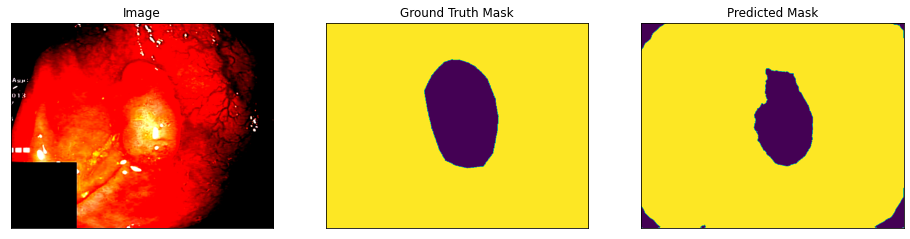

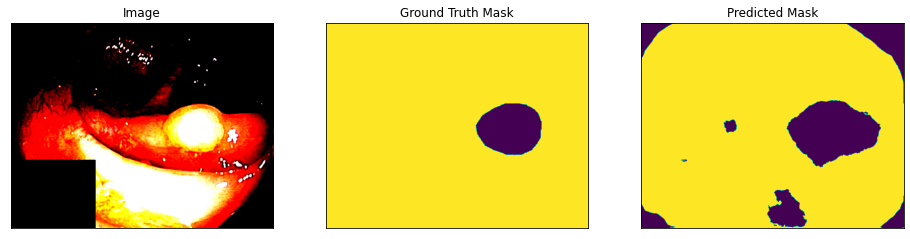

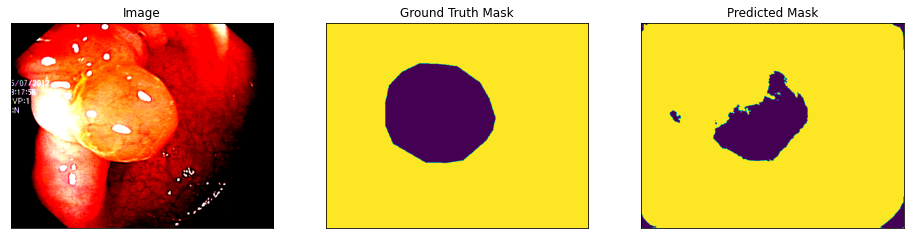

In [25]:
for i in range(NUM_EXPS):
  if hps.iloc[i]['tested_yet'] == 'no':
  
    exp_num = hps.iloc[i]['experiment_num']
    print('running experiment number ' + str(exp_num))
    
    if hps.iloc[i]['decoder_attention_type'] == 'None':
      DECODER_ATTENTION_TYPE = None
    else:
      DECODER_ATTENTION_TYPE = hps.iloc[i]['decoder_attention_type']
    

    ENCODER_DEPTH = hps.iloc[i]['encoder_depth']
    if ENCODER_DEPTH == 5:
      DECODER_CHANNELS = (256, 128, 64, 32, 16)
    elif ENCODER_DEPTH == 4:
      DECODER_CHANNELS = (128, 64, 32, 16)
    else:
      DECODER_CHANNELS = (64, 32, 16)

    logdir = "./drive/MyDrive/ColabNotebooks/AppliedDeepLearning/hyperparameter_logs/segmentation_notebook_experiment_" + str(exp_num)

    if not os.path.exists(logdir):
      os.makedirs(logdir)

    # create segmentation model with pretrained encoder

    model = smp.UnetPlusPlus(
      encoder_name=ENCODER, 
      encoder_weights=ENCODER_WEIGHTS, 
      encoder_depth=ENCODER_DEPTH,
      decoder_channels=DECODER_CHANNELS,
      classes=len(CLASSES), 
      activation=ACTIVATION,
      decoder_attention_type=DECODER_ATTENTION_TYPE,
    )
    
    preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
    train_dataset = Dataset(
        x_train_dir, 
        y_train_dir, 
        augmentation=get_training_augmentation(), 
        preprocessing=get_preprocessing(preprocessing_fn),
        classes=CLASSES,
    )

    valid_dataset = Dataset(
        x_valid_dir, 
        y_valid_dir, 
        augmentation=get_validation_augmentation(), 
        preprocessing=get_preprocessing(preprocessing_fn),
        classes=CLASSES,
    )

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=12)
    valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

    # experiment setup
    num_epochs = 20
    UtilsFactory.plot_metrics(logdir=logdir)
    loaders = {
        "train": train_loader,
        "valid": valid_loader
    }

    # model, criterion, optimizer
    # model = # already defined
    criterion = smp.losses.DiceLoss(mode='binary')  #BCEDiceLoss(eps=1.)
    optimizer = torch.optim.Adam([
        {'params': model.decoder.parameters(), 'lr': hps.iloc[i]['decoder_lr']}, 
        
        # decrease lr for encoder in order not to permute 
        # pre-trained weights with large gradients on training start
        {'params': model.encoder.parameters(), 'lr': hps.iloc[i]['encoder_lr']},  
    ])
    scheduler = None

    # @TODO: add metrics support 
    # (catalyst expects logits, rather than sigmoid outputs)
    #metrics = [
    #     smp.  metrics.iou_score() 
        #IoUMetric(eps=1.),
        #smp.utils.metrics.FscoreMetric(eps=1.),
    #]


    # model runner
    runner = SupervisedRunner()

    # model training
    runner.train(
        model=model,
        criterion=criterion,
        callbacks=[
            EarlyStoppingCallback(
                patience=3, metric="loss", minimize=True
            )
        ],
        optimizer=optimizer,
        loaders=loaders,
        logdir=logdir,
        num_epochs=num_epochs,
        verbose=True
    )

    # create test dataset
    test_dataset = Dataset(
        x_test_dir, 
        y_test_dir, 
        augmentation=get_validation_augmentation(), 
        preprocessing=get_preprocessing(preprocessing_fn),
        classes=CLASSES,
    )

    test_dataloader = DataLoader(test_dataset)

    loaders = {"infer": test_dataloader}
    runner.infer(
        model=model,
        loaders=loaders,
        callbacks=[
            CheckpointCallback(
                resume=f"{logdir}/checkpoints/best.pth"),
            InferCallback()
        ],
    )

    threshold = 0.5
    break_at = 2
    
    j = 0
    for i, (input, output) in enumerate(zip(
            test_dataset, runner.callbacks[1].predictions["logits"])):
        image, mask = input
        
        image_vis = image.transpose(1, 2, 0)
        gt_mask = mask[0].astype('uint8')
        pr_mask = (output[0] > threshold).astype('uint8')
            
        visualize(save=True, folder=logdir, number=j,
            image=image_vis, 
            ground_truth_mask=gt_mask, 
            predicted_mask=pr_mask
        )
        j = j + 1
        
        if i >= break_at:
          break
    
    hps.iloc[i, 5] = 'yes'
    hps.to_csv('./drive/MyDrive/ColabNotebooks/AppliedDeepLearning/hyperparameters_unetplusplus.csv')

    torch.cuda.empty_cache()
    del model
    del runner
    #del train_dataset
    #del valid_dataset
    gc.collect()